# Take-off Delay Prediction Machine Learning Model

![스크린샷 2021-09-02 04 17 27](https://user-images.githubusercontent.com/79494088/131732539-d5002f1d-43a2-4814-858a-b67275437388.png)


- 항공교통 수요가 지속적으로 증가함에 따라 항공기 지연으로 인한 이용자들의 불편과 피해가 늘어나고 있다.
- 지연 발생 시 공항, 항공사, 항공교통이용자 모두에게 시간적·금전적 손해가 발생하며 공항 운영에 있어 상당한 피해를 입게 된다.
- 지연 발생을 예측할 수 있다면 공항 및 항공사 관계자가 사전에 공항운영에 대한 적절한 조치를 취할 수 있어 소비자가 입을 추가적인 피해에 대비할 수 있다.
- 다양한 사유를 통해 정상착륙, 지연으로의 분류 문제로 예측하고자 한다.
- 이를 통하여 소비자의 편익이 증진될 뿐 아니라, 항공사와 공항의 효율성과 비용절감에도 기여할 수 있을 것으로 기대한다.

In [ ]:
!pip install -U imbalanced-learn
!pip install category_encoders
!pip install scikit-learn  -U # 최종 'str' object has no attribute 'decode' 에러 해결
!pip install catboost
!pip install shapely
!pip install pdpbox
!pip install eli5
!pip install shap

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MinMaxScaler
from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot
from scipy.stats import randint, uniform
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from ipywidgets import interact, fixed
from imblearn.under_sampling import *
from imblearn.over_sampling import *
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import xgboost
import eli5
import shap


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 선정 이유 및 문제 정의
- 해결하고자 하는 문제 : 항공기 착륙 지연 예측
- 답을 얻기 위한 데이터 : 캐글의 '2015 Flight Delays and Cancellations' 데이터
- 선정이유
  - 항공 승무원이었던 경력을 살려 깊게 파고들 수 있는 도메인이기에 골랐다.
  - 사용할 타겟 특성은 result으로 15분 이상 지연되었는지를 확인할 수 있는 binary값이다.
  - 전체 데이터로 실험해보고 싶지만, Cost의 한계로 1월의 Small Data로 진행해보고자 한다.
  - 풀고자 하는 문제는 분류문제이며 여러가지 상황에 따라 항공기 착륙이 지연될지, 지연되지 않을지를 예측하는 모델링을 할 것이다.
  - 데이터에서 도착과 관련된 정보를 모두 제거하여 항공기가 Take-off함과 동시에 지연을 에측하는 모델링을 할 것이다.


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/flights.csv')
airlines = pd.read_csv('/content/drive/MyDrive/airlines.csv')

# Cost의 한계로 10만개의 data로 진행
train = train[0:100000]
train

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2015,1,7,3,EV,4992,N837AS,ATL,BQK,1108,1102.0,-6.0,23.0,1125.0,71.0,66.0,40.0,238,1205.0,3.0,1219,1208.0,-11.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
99996,2015,1,7,3,NK,394,N522NK,LAS,PHL,1108,1117.0,9.0,11.0,1128.0,274.0,267.0,248.0,2176,1836.0,8.0,1842,1844.0,2.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
99997,2015,1,7,3,OO,5606,N582SW,SFO,BFL,1108,1101.0,-7.0,28.0,1129.0,77.0,91.0,59.0,238,1228.0,4.0,1225,1232.0,7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
99998,2015,1,7,3,UA,1135,N38473,ORD,MCO,1109,1116.0,7.0,26.0,1142.0,165.0,157.0,123.0,1005,1445.0,8.0,1454,1453.0,-1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 컬럼 확인
train.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

In [ ]:
'''
ㅁ데이터 컬럼 설명
    YEAR                        
    MONTH                       
    DAY                         
    DAY_OF_WEEK                 
    AIRLINE                     항공사
    FLIGHT_NUMBER               항공편
    TAIL_NUMBER                 항공기
    ORIGIN_AIRPORT              출발 공항
    DESTINATION_AIRPORT         목적지 공항
    SCHEDULED_DEPARTURE         출발 예정시간
    DEPARTURE_TIME              출발 시간
    DEPARTURE_DELAY             총 출발 지연
    TAXI_OUT                    게이트에서 출발할 때까지의 경과 시간
    WHEELS_OFF                  항공기의 바퀴가 지면을 떠나는 시점
    SCHEDULED_TIME              비행 계획 시간
    ELAPSED_TIME                경과 시간 = AIR_TIME + TAXI_IN + TAXI_OUT
    AIR_TIME                    WHEELS_OFF과 WHEELS_ON 사이의 시간
    DISTANCE                    두 공항 간의 거리
    WHEELS_ON                   항공기 바퀴가 지면에 닿는 시점
    TAXI_IN                     목적지 공항에 게이트 도착까지 경과된 시간
    SCHEDULED_ARRIVAL           예정 도착 시간
    ARRIVAL_TIME                도착 시간
    ARRIVAL_DELAY               지연 시간
    DIVERTED                    지연
    CANCELLED                   취소
    CANCELLATION_REASON         취소 사유
    AIR_SYSTEM_DELAY            에어 시스템
    SECURITY_DELAY              보안
    AIRLINE_DELAY               항공사
    LATE_AIRCRAFT_DELAY         항공기
    WEATHER_DELAY               날씨
'''

In [ ]:
# 결측치 확인
train.isnull().sum()

AIRLINE                   0
TAIL_NUMBER             167
ORIGIN_AIRPORT            0
DESTINATION_AIRPORT       0
SCHEDULED_DEPARTURE       0
DEPARTURE_TIME         2298
DEPARTURE_DELAY        2298
TAXI_OUT               2371
WHEELS_OFF             2371
SCHEDULED_TIME            0
DISTANCE                  0
SCHEDULED_ARRIVAL         0
result                    0
dtype: int64

- 현재도 임의로 10만개로 줄여서 데이터를 사용중이기 때문에 3% 비율만 차지하기도 하고, 정확한 모델링을 위해서 결측치는 모두 제거한다. 

In [ ]:
train.dtypes

AIRLINE                 object
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
DISTANCE                 int64
SCHEDULED_ARRIVAL        int64
result                   int64
dtype: object

# 가설 및 평가지표, Baseline
- 가설
  - 출발 예정시간보다 출발에 지연된 시간이 클 수록 착륙 지연 확률은 늘어날 것이다.
  - 지연이 잦은 항공사가 있으므로 지연 확률을 줄이기 위한 고려사항이 된다.
  - 공항의 복잡도 고려 착륙지연이 잦은 출발 공항일 수록 도착 공항으로서의 지연도 잦다.
- Target 특성으로는 15분 이상 지연 됐을 지를 표시하는 새로운 column을 생성했다.
- Baseline Model로는 초기 최빈값 정확도 0.65에서 RandomForest의 AUC Score로 변경하였다.

# EDA
- 원하는 모델링을 위해 Feature Engineering 바로 진행


In [ ]:
def engineering(df):
    # 도착 지연을 예측해야 하므로 도착정보에 관한 컬럼과 필요없는 컬럼은 제거한다.
    df = df[['AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
        'WHEELS_OFF', 'SCHEDULED_TIME', 'DISTANCE',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_DELAY']]
    # 15분 이상 지연되었다는 것을 표시하는 컬럼을 새로 만든다.
    result=[]

    for row in df['ARRIVAL_DELAY']:
        if row > 15:
            result.append(1)
        else:
            result.append(0)  

    df['result'] = result
    
    # 분류 컬럼을 만들었으니 예측을 위해 기존 컬럼 삭제
    df = df.drop(['ARRIVAL_DELAY'], axis = 1)

    # 결측치 제거
    df = df.dropna()
    return df

train = engineering(train)

In [ ]:
train

,result,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL
9890,0,4,365,7,22,1700,1709.0,9.0,16.0,1725.0,121.0,599,1801
35860,1,8,233,82,12,1041,1114.0,33.0,23.0,1137.0,192.0,1076,1353
77831,0,2,650,25,2,2035,2055.0,20.0,12.0,2107.0,150.0,1102,5
42123,1,1,1044,21,54,1725,1752.0,27.0,17.0,1809.0,325.0,2149,1950
23471,0,4,2801,11,6,1436,1432.0,-4.0,15.0,1447.0,189.0,1276,1845
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51587,1,10,1052,46,25,1051,1153.0,62.0,14.0,1207.0,74.0,317,1205
4119,1,12,1220,11,45,1055,1131.0,36.0,19.0,1150.0,65.0,255,1100
60529,0,1,5,5,10,1950,1942.0,-8.0,20.0,2002.0,136.0,763,2206
63060,0,10,1003,92,13,600,554.0,-6.0,23.0,617.0,123.0,599,703


In [ ]:
# 범주 확인
unicol = ['AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
for i in unicol:
    print(i, train[i].unique())

AIRLINE ['AS' 'AA' 'US' 'DL' 'NK' 'UA' 'HA' 'B6' 'OO' 'EV' 'F9' 'WN' 'MQ' 'VX']
TAIL_NUMBER ['N407AS' 'N3KUAA' 'N171US' ... 'N29907' 'N66051' 'N808NW']
ORIGIN_AIRPORT ['ANC' 'LAX' 'SFO' 'SEA' 'LAS' 'DEN' 'SLC' 'PDX' 'FAI' 'MSP' 'PHX' 'SJU'
 'PBG' 'IAG' 'PSE' 'BQN' 'ORD' 'GEG' 'HNL' 'ONT' 'MCO' 'BOS' 'HIB' 'ABR'
 'DFW' 'MKE' 'IAH' 'BNA' 'BRO' 'VPS' 'BOI' 'BJI' 'PHL' 'SBN' 'EUG' 'IAD'
 'BUF' 'PWM' 'JFK' 'CRP' 'PIA' 'FAT' 'SMF' 'AUS' 'MCI' 'ATL' 'JAX' 'MFR'
 'IDA' 'MSN' 'DCA' 'SAT' 'CHS' 'SBA' 'IND' 'CLE' 'GSP' 'BDL' 'RIC' 'BFL'
 'OMA' 'RDM' 'FLL' 'CID' 'TPA' 'SYR' 'ROC' 'TYR' 'LAN' 'GSO' 'EWR' 'PBI'
 'RSW' 'OAK' 'PVD' 'RNO' 'PIT' 'ABQ' 'MIA' 'BWI' 'TUL' 'LGA' 'LIT' 'MSY'
 'OKC' 'ATW' 'PNS' 'MEM' 'TYS' 'MHT' 'SAV' 'CLT' 'GRB' 'ABE' 'JAN' 'OAJ'
 'FAR' 'ERI' 'LEX' 'CWA' 'TTN' 'RDU' 'CVG' 'BHM' 'ACY' 'DTW' 'RAP' 'TUS'
 'EAU' 'DLH' 'FSD' 'INL' 'SPI' 'CLD' 'COD' 'CMH' 'PSC' 'CPR' 'ACV' 'DAL'
 'PAH' 'MRY' 'ESC' 'ISN' 'PSP' 'CAE' 'STL' 'BTV' 'MTJ' 'GCC' 'OGG' 'SJC'
 'GUC' 'ORF' 'MOT' 'MLU' 'KOA'

In [ ]:
# 타겟 특성 : result
train.describe().T

,count,mean,std,min,25%,50%,75%,max
SCHEDULED_DEPARTURE,97629.0,1306.572289,481.983287,5.0,905.0,1300.0,1719.0,2359.0
DEPARTURE_TIME,97629.0,1326.147169,503.342910,1.0,911.0,1317.0,1738.0,2400.0
DEPARTURE_DELAY,97629.0,19.896506,45.779110,-39.0,-3.0,3.0,25.0,1380.0
TAXI_OUT,97629.0,17.155917,10.738373,1.0,11.0,14.0,20.0,176.0
WHEELS_OFF,97629.0,1348.426154,504.142807,1.0,928.0,1330.0,1753.0,2400.0
SCHEDULED_TIME,97629.0,143.915527,76.534894,23.0,87.0,125.0,177.0,718.0
DISTANCE,97629.0,837.647912,611.493337,31.0,388.0,677.0,1076.0,4983.0
SCHEDULED_ARRIVAL,97629.0,1482.164470,498.563139,1.0,1103.0,1500.0,1908.0,2359.0
result,97629.0,0.344242,0.475123,0.0,0.0,0.0,1.0,1.0


0    0.655758
1    0.344242
Name: result, dtype: float64


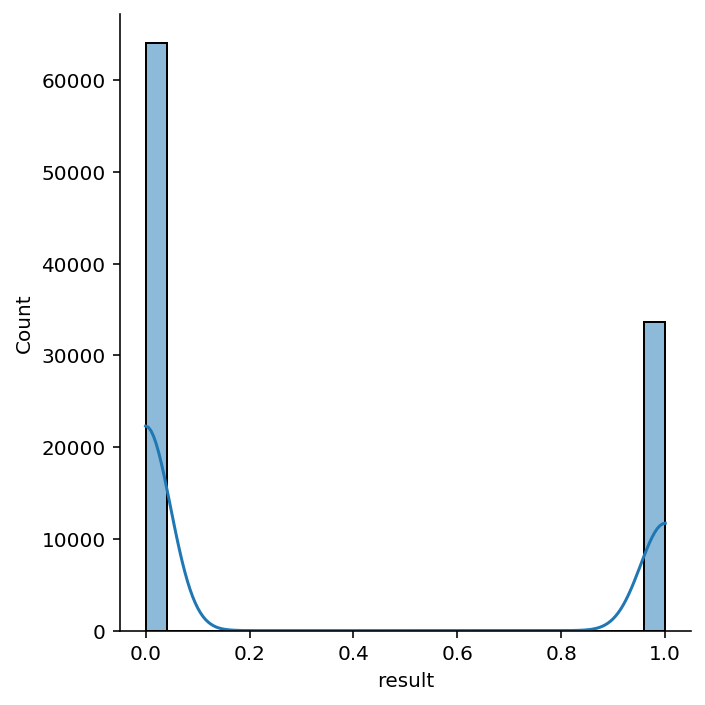

In [ ]:
# 분포확인
print(train['result'].value_counts(normalize=True))
sns.displot(train['result'],kde=True);

- 약간은 불균형하다.
- 최빈값인 ‘0.66’을 초기 정확도 Baseline으로 잡아둔다.
- 나중에 `scale_pos_weight`를 위해 ratio를 계산해둔다.
- Hyperparameter tuning만으로 부족하다면 smote도 고려해둔다.

In [ ]:
ratio = 0.654903 / 0.345097
ratio

1.8977359988640876

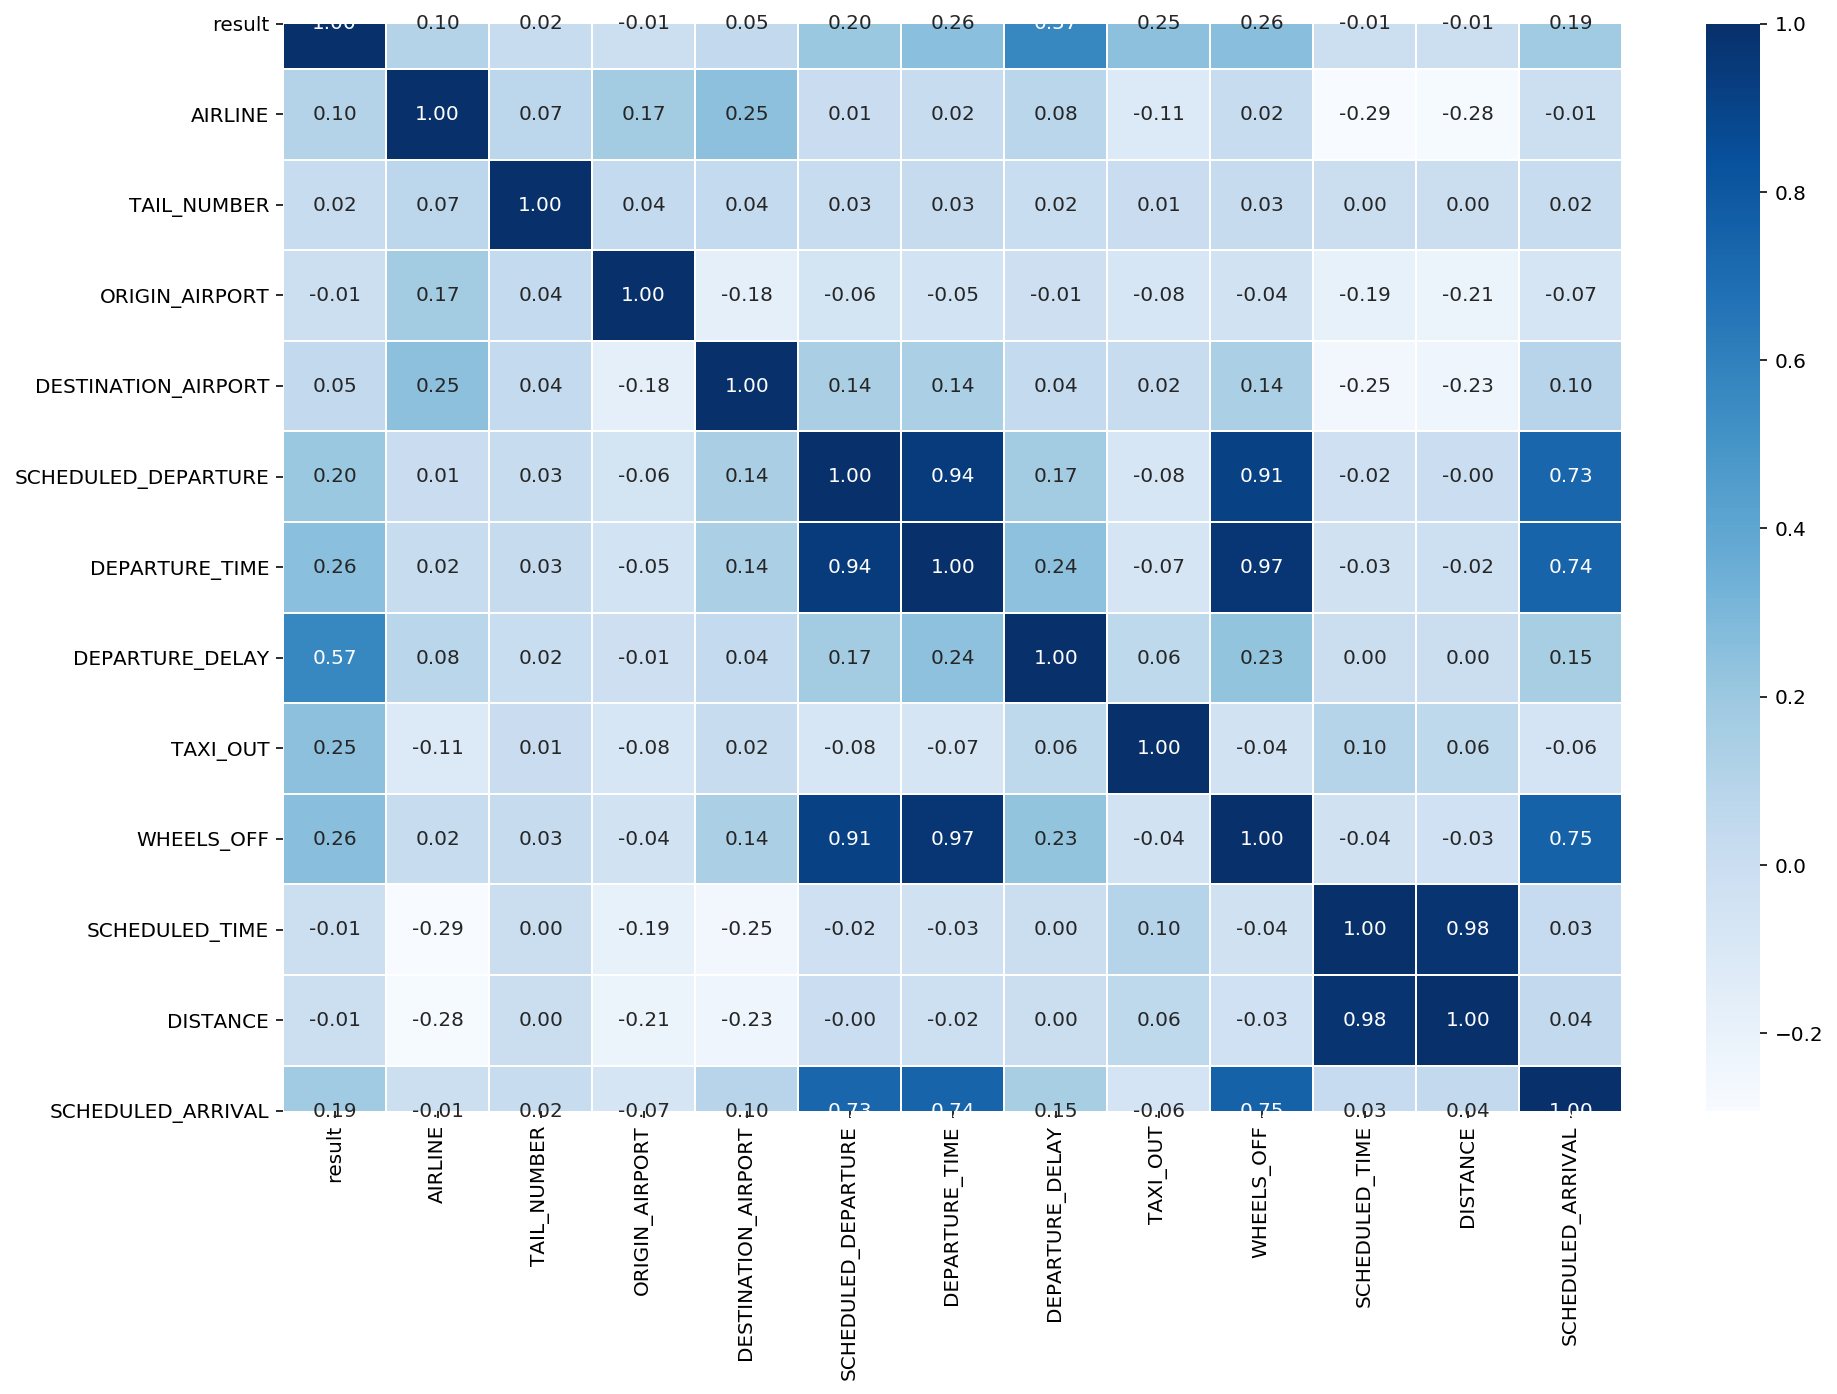

In [ ]:
# 상관관계 시각화
new = train['result']
train = train.drop(['result'], axis = 1)
train = pd.concat([new, train], axis = 1)
plt.figure(figsize = (15,10))
sns.heatmap(data = train.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues');

- 피쳐들간의 상관관계가 높은 경우가 종종 있으나, 분류문제이기 때문에 무시한다.

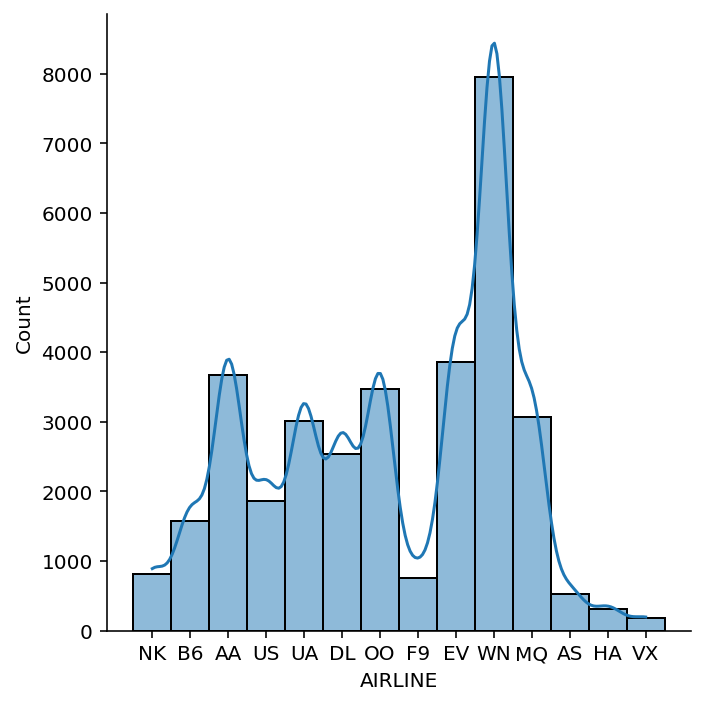

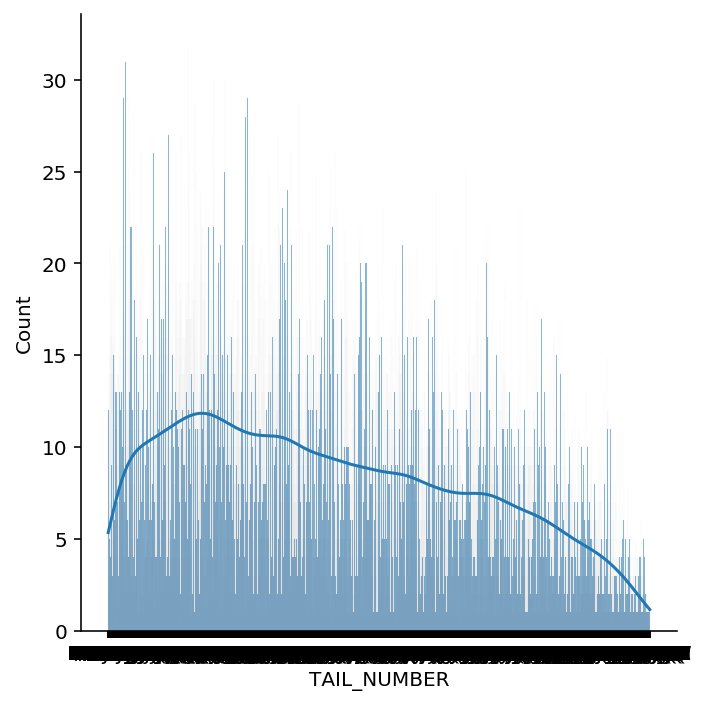

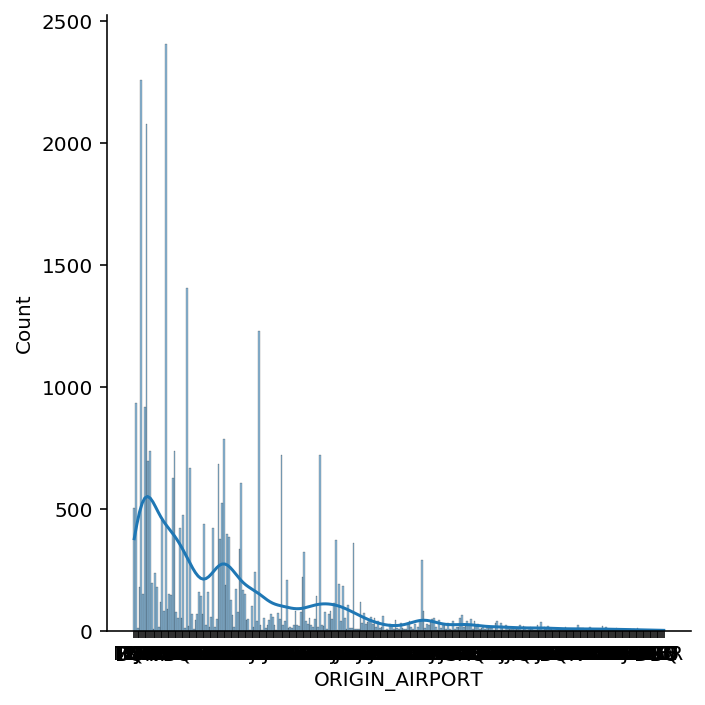

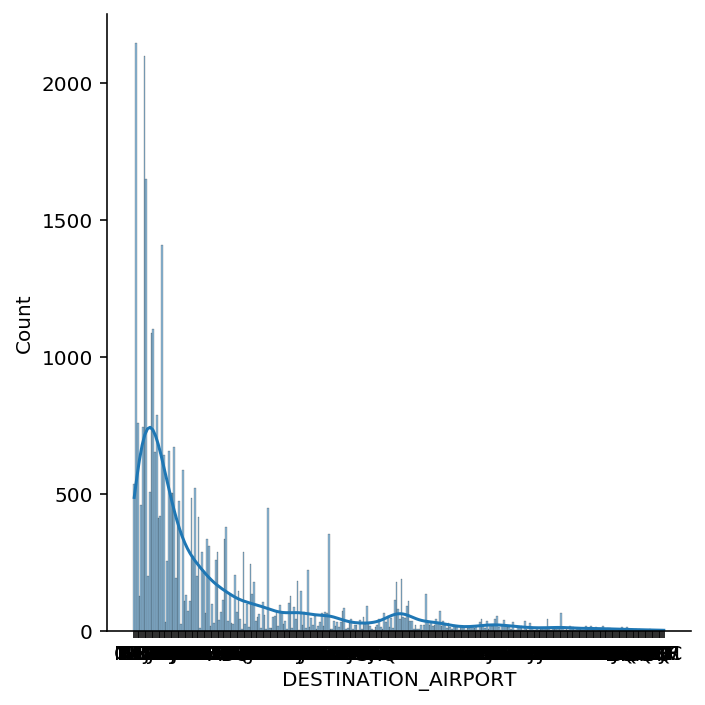

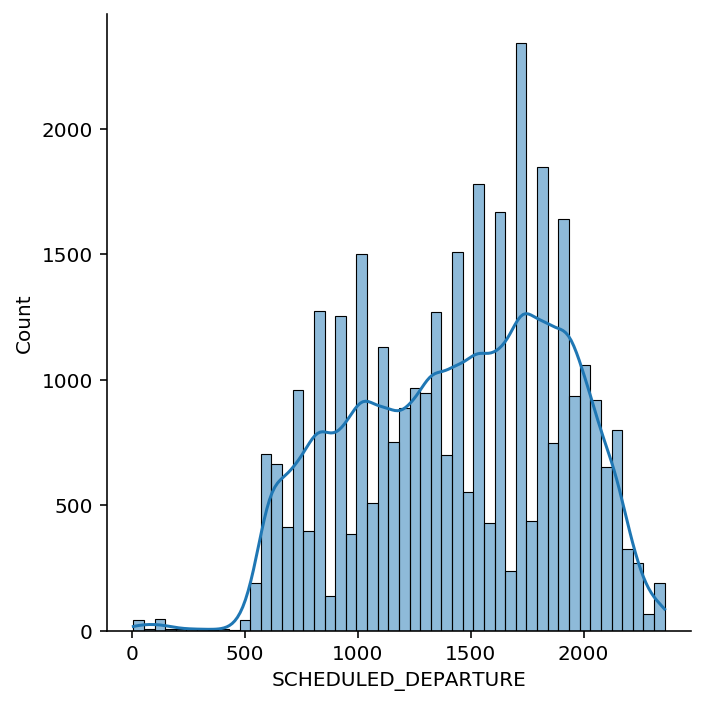

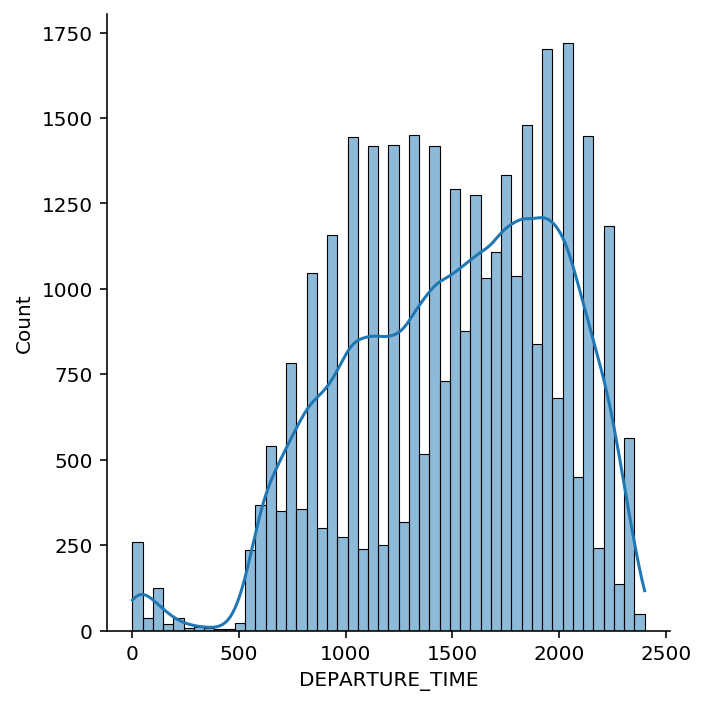

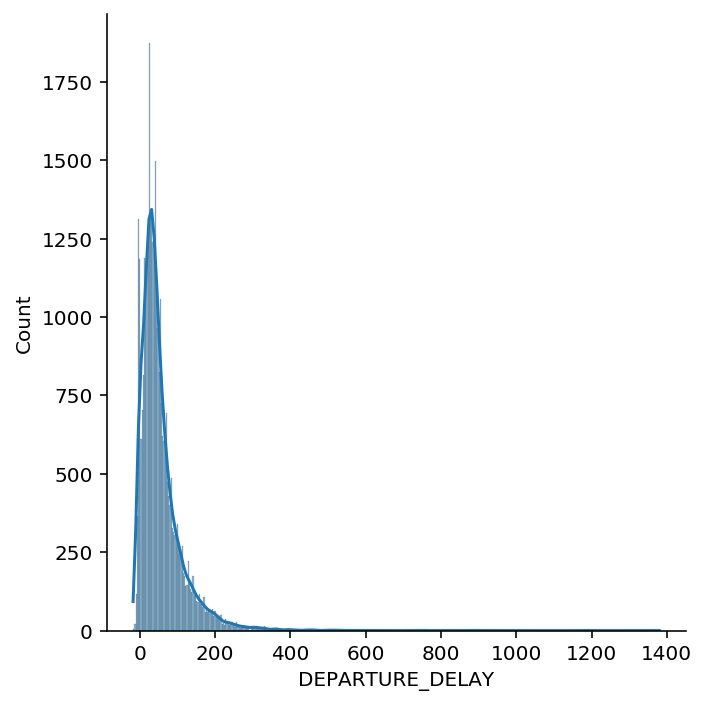

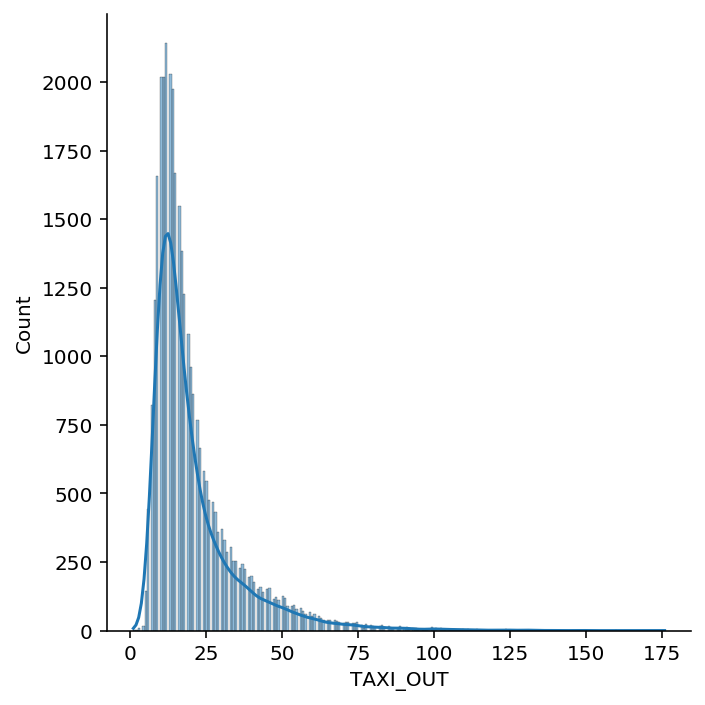

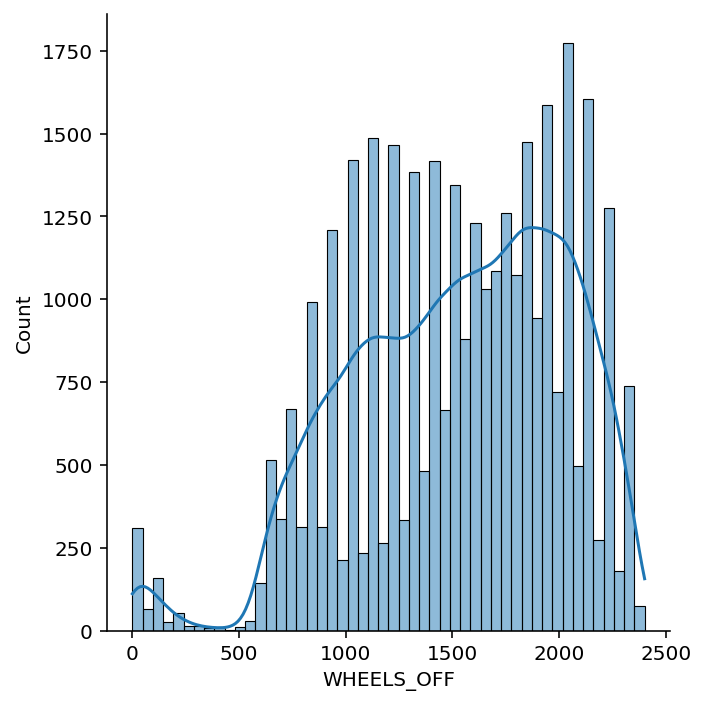

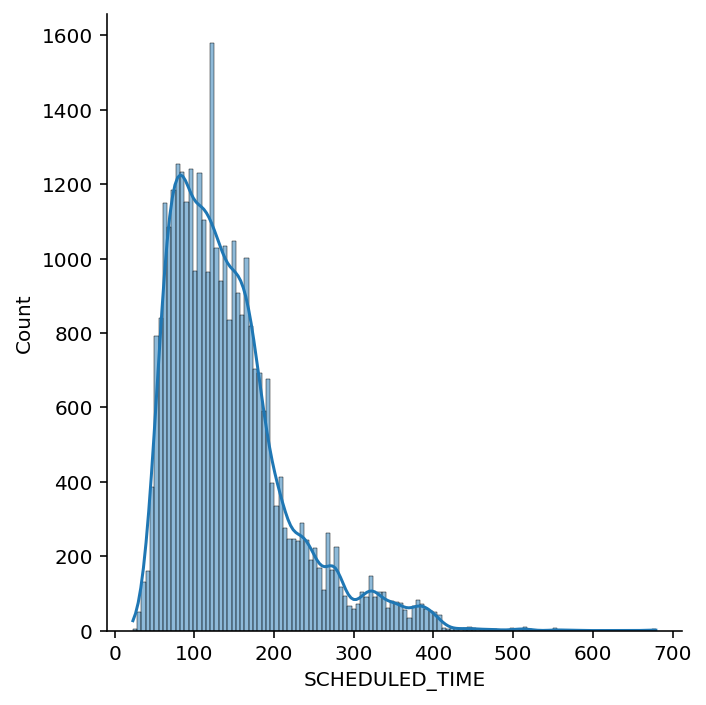

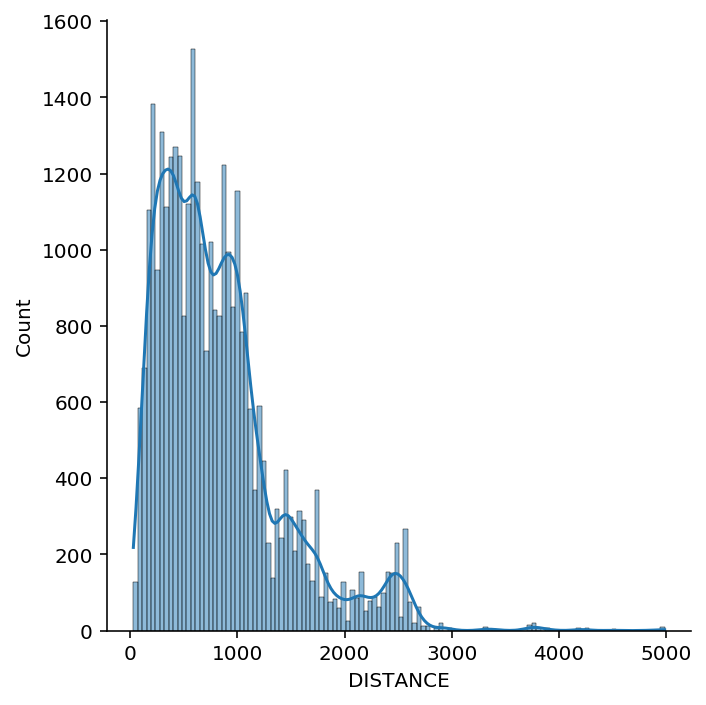

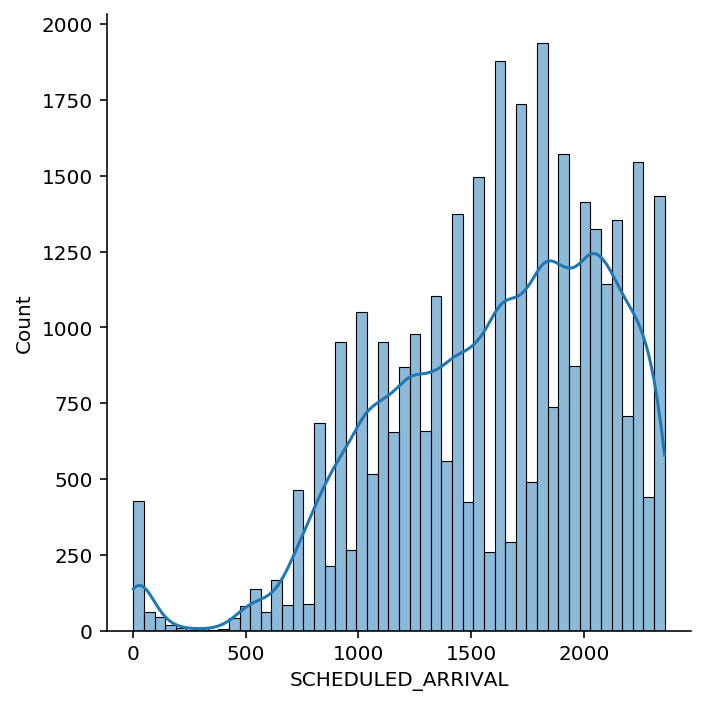

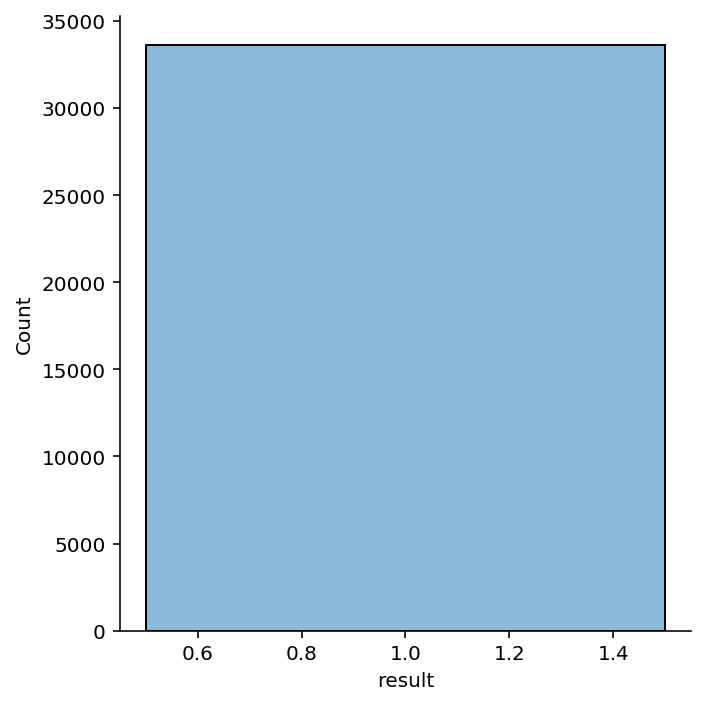

In [ ]:
# 특성별 분포확인
delay = train[train.result == 1]
delay.shape
dp = train.columns
for i in dp:
    sns.displot(delay[i],kde=True);

In [ ]:
delay = train[train.result == 1]
delay.shape

(33608, 13)

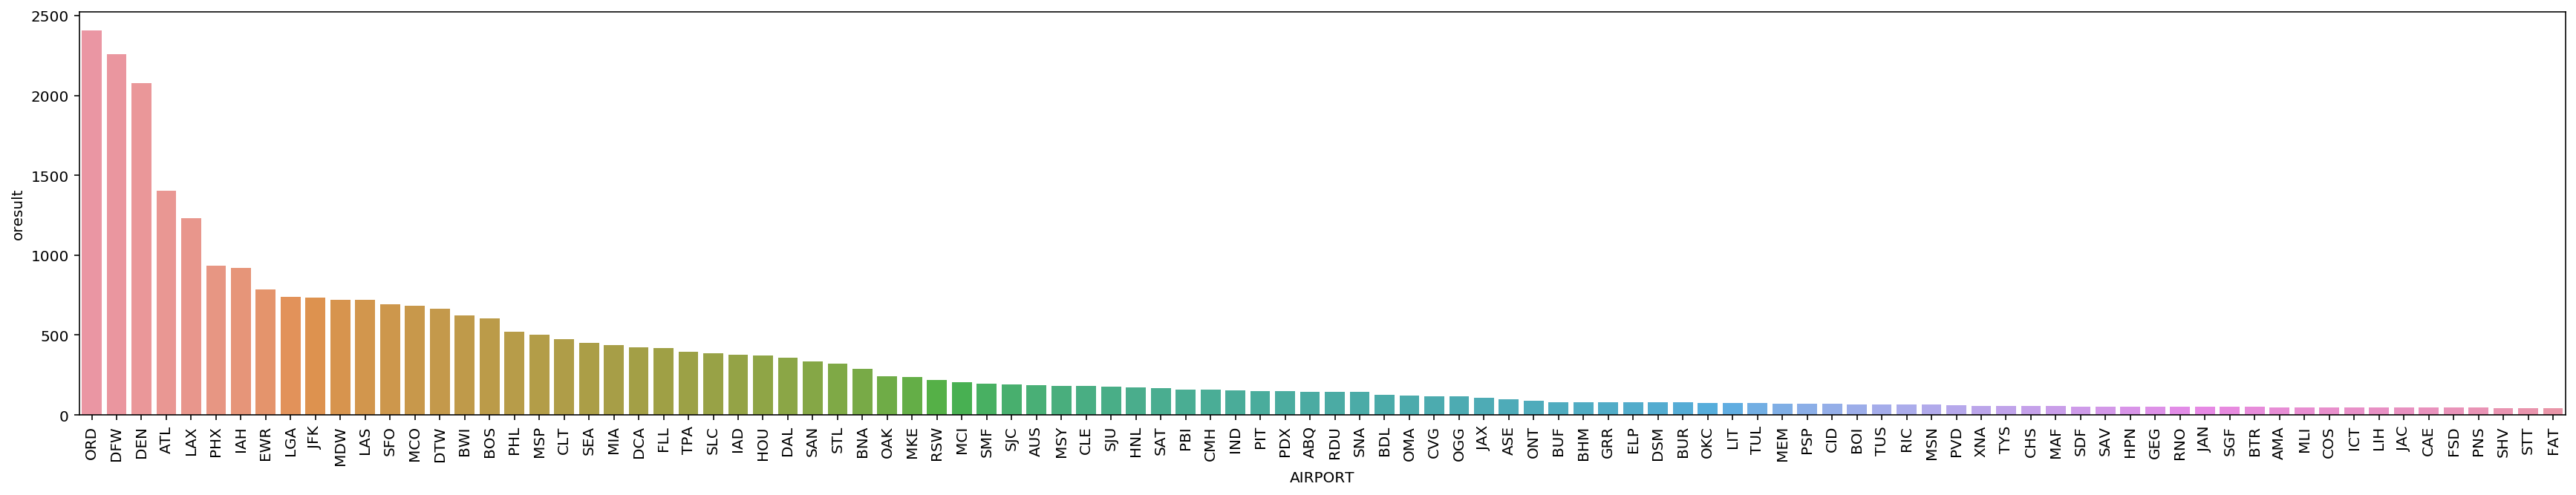

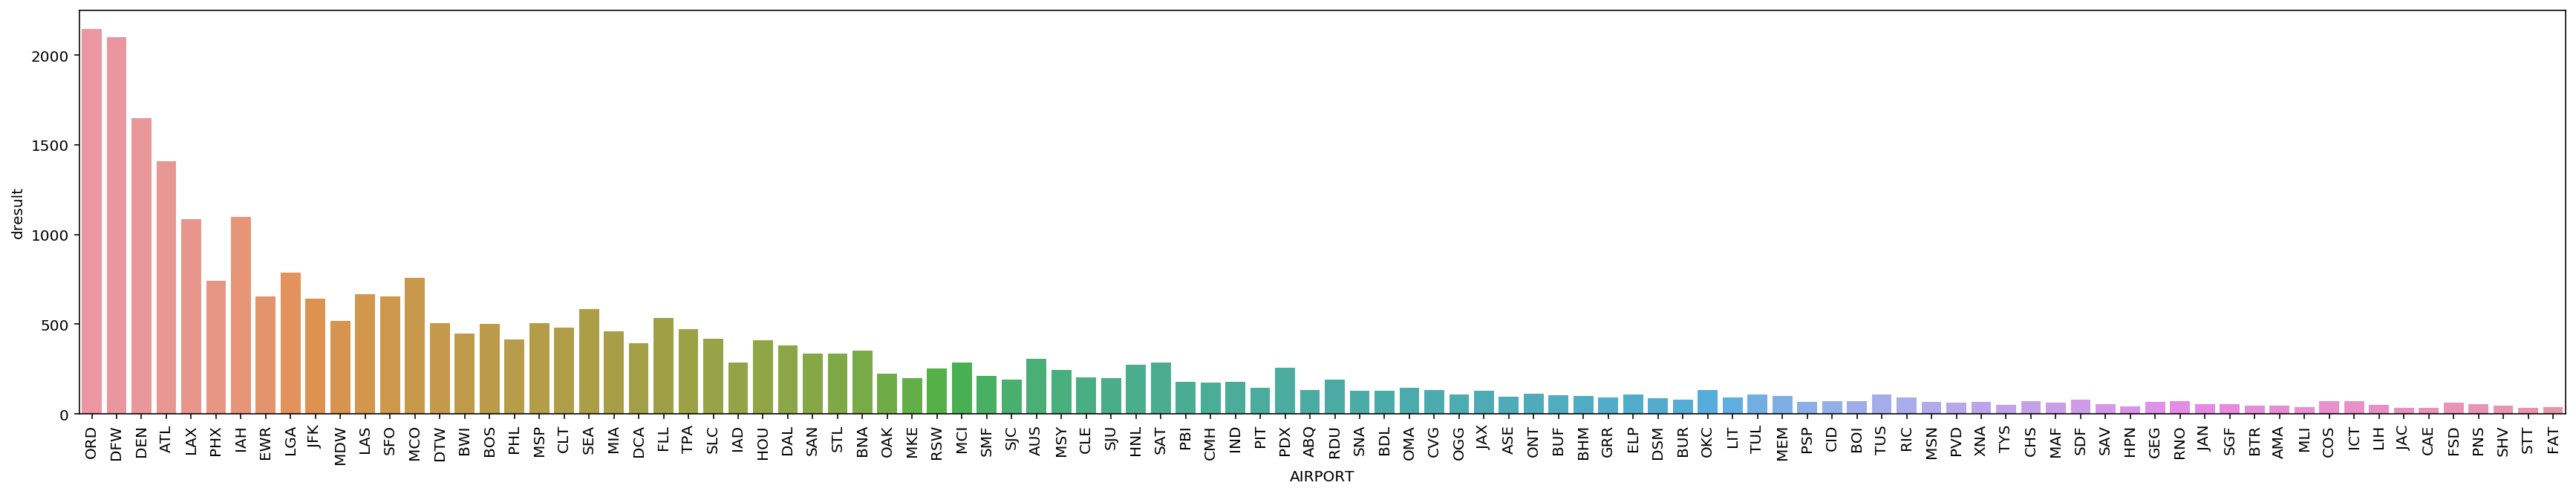

In [ ]:
oa_del = delay['ORIGIN_AIRPORT'].value_counts().reset_index().rename(columns={'index':'AIRPORT', 'ORIGIN_AIRPORT':'oresult'})
da_del = delay['DESTINATION_AIRPORT'].value_counts().reset_index().rename(columns={'index':'AIRPORT', 'DESTINATION_AIRPORT':'dresult'})
oda_del = pd.merge(oa_del, da_del, how='left', on='AIRPORT')
oda_del = oda_del[:100]

for col in oda_del.columns[1:]:
    plt.figure(figsize=(30,5))
    sns.barplot(x = 'AIRPORT', y = col, data = oda_del)
    plt.xticks(rotation=90)
    plt.show()

## 가설 3 : 공학의 복잡도 고려 착륙지연이 잦은 출발 공항일 수록 도착 공항으로서의 지연도 잦다.
- 출발공항일 때와 도착공항 일 때의 지연 횟수가 유의미하게 상관관계가 있음을 확인할 수 있다.
- 그래프로 미루어보아 공항의 복잡도 고려 착륙지연이 잦은 출발 공항일 수록 도착 공항으로서의 지연도 잦음을 알 수 있다.

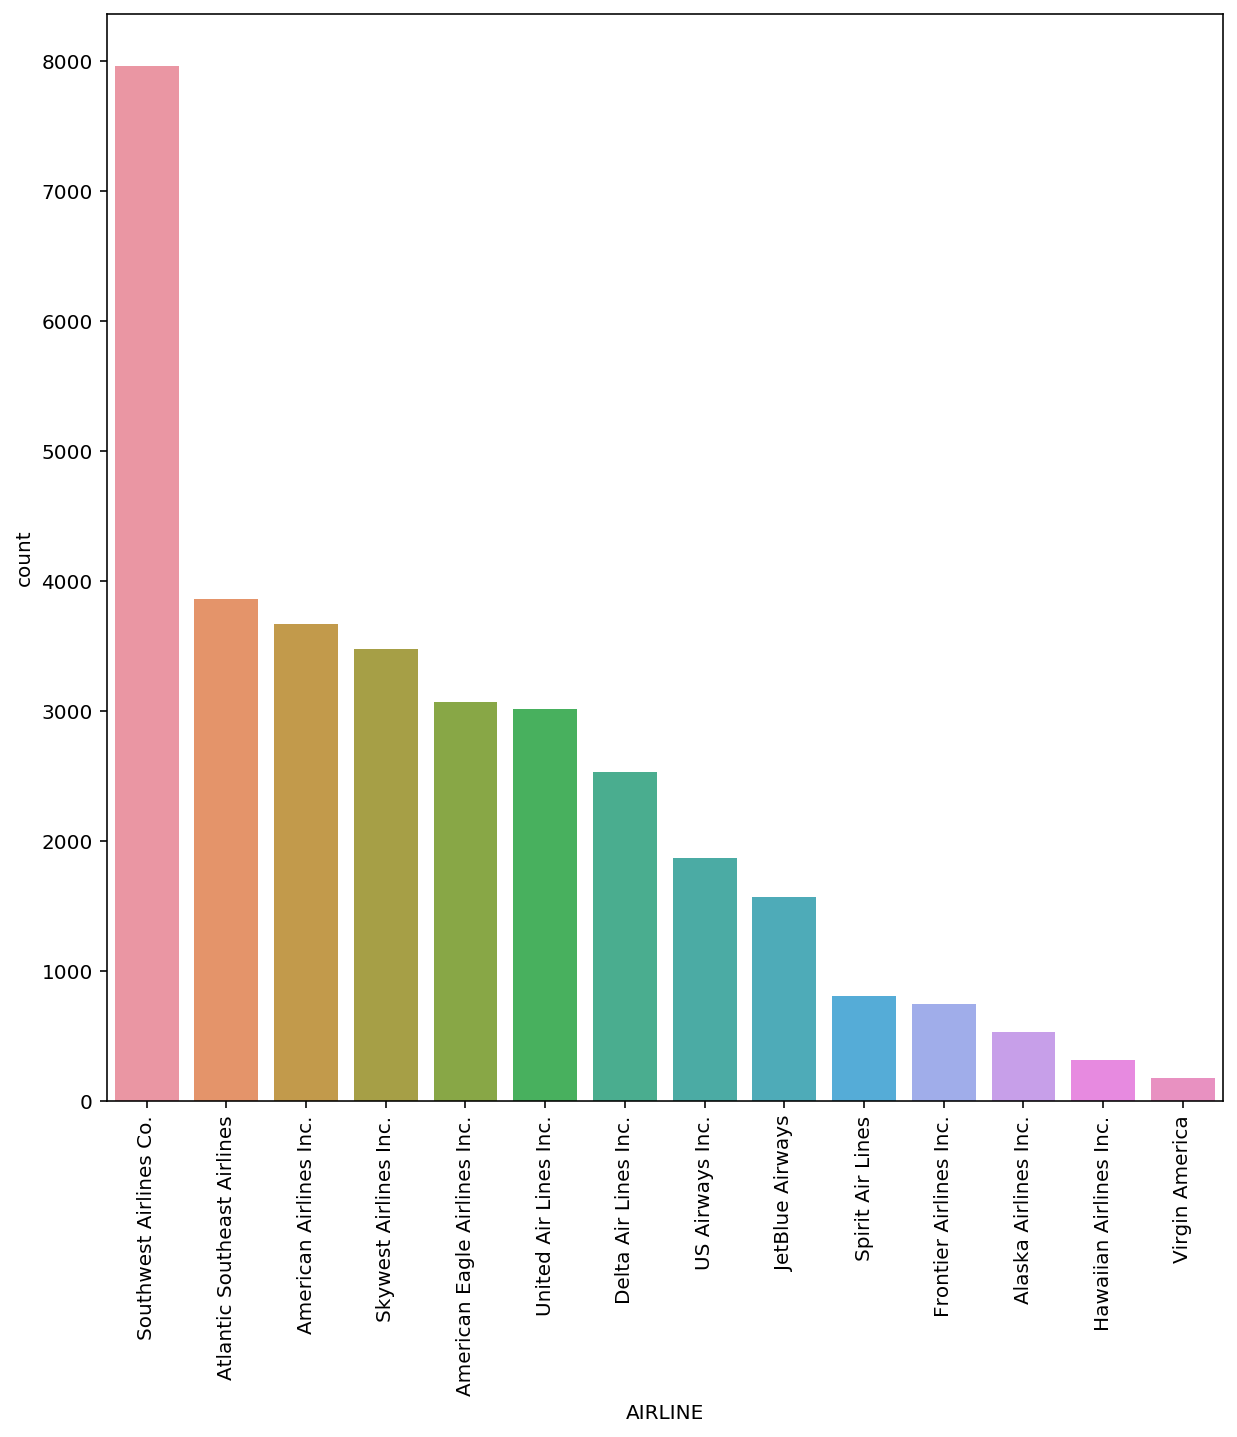

In [ ]:
a_del = delay['AIRLINE'].value_counts().reset_index().rename(columns={'index':'IATA_CODE', 'AIRLINE':'count'})
a_del = pd.merge(a_del, airlines, how='left', on='IATA_CODE')

plt.figure(figsize=(10,10))
sns.barplot(x = 'AIRLINE', y = 'count', data = a_del)
plt.xticks(rotation=90)
plt.show()

## 가설 2 : 지연이 잦은 항공사가 있으므로 지연 확률을 줄이기 위한 고려사항이 된다.
- 유독 Southwest Airlines가 도착 지연이 잦은 것을 확인할 수 있다.
- 그래프로 미루어보아 지연 확률을 줄이기 위해서 항공사를 잘 선택하는 것도 고려사항임을 알 수 있다.

# 모델의 유용성 및 한계
- 만들고자 하는 모델의 경우 항공기의 바퀴가 지면에서 띄워지는 순간에 착륙 지연을 예측할 수 있다.
- 이는 이륙하자마자 전 승객에게 착륙 지연 여부를 알려줄 수 있기 때문에 유용할 뿐 아니라, 도착 공항이나 항공사에서도 대비를 할 수 있을거라 생각한다.
- 하지만 이륙 시 통신이 두절되는 항공기의 특성 상 승객이 대비할 수 있는 여건은 마련되지 않는다.

# Modeling

## 1차 모델링(Baseline)


In [ ]:
# 오디널인코딩
encoder = OrdinalEncoder()
train = encoder.fit_transform(train)

In [ ]:
# 학습/검증/테스트 타겟 생성 및 분리
target = 'result'
train, test = train_test_split(train, test_size=0.20, stratify=train[target], random_state=2)
train, val = train_test_split(train, test_size=0.20, stratify=train[target], random_state=2)
train.shape, val.shape, test.shape

((62482, 13), (15621, 13), (19526, 13))

In [ ]:
# 타겟 지정
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

X_train.shape, X_val.shape, X_test.shape

((62482, 12), (15621, 12), (19526, 12))

In [ ]:
# 간단한 모델링 : Randomforest
# 평가지표로 정확도뿐 아니라 Precision, Recall, f1, AUC까지 확인 예정
model = RandomForestClassifier(n_jobs=-1, random_state=2)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print('훈련 정확도', model.score(X_train, y_train))
print('검증 정확도', model.score(X_val, y_val))
print('Report \n',classification_report(y_val, y_pred))
print('f1 스코어',f1_score(y_val, y_pred))
print('auc점수 : ', roc_auc_score(y_val, y_pred))

훈련 정확도 1.0
검증 정확도 0.9143743122936882
Report 
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      6556
           1       0.91      0.83      0.87      3441

    accuracy                           0.91      9997
   macro avg       0.91      0.90      0.90      9997
weighted avg       0.91      0.91      0.91      9997

f1 스코어 0.8700667880995749
auc점수 :  0.8950179563136914


- RandomForest를 이용하여 1차 Baseline Modeling을 진행했다.
- Parameter없이 간단히 진행하였으며, 정확도를 보면 과적합이 확인되지만, 검증 Set에서의 정확도가 최빈값 baseline을 넘었으므로 이번 Modeling에서 유심히 볼 평가지표인 ‘AUC Score’를 Baseline으로 두고 진행한다.
- 정확도, 정밀도와 재현율이 포함된 F1도 함께 확인하며 진행하지만 신호탐지이론에서 적중확률 대 오경보확률의 그래프를 점수화 한 AUC Score를 중점으로 두고 진행한다.

## 2차 모델링

In [ ]:
# 캣부스트 사용
model = CatBoostClassifier()

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print('훈련 정확도', model.score(X_train, y_train))
print('검증 정확도', model.score(X_val, y_val))
print('Report \n',classification_report(y_val, y_pred))
print('f1 스코어',f1_score(y_val, y_pred))
print('auc점수 : ', roc_auc_score(y_val, y_pred))

Learning rate set to 0.060217
0:	learn: 0.6205995	total: 77.8ms	remaining: 1m 17s
1:	learn: 0.5631503	total: 103ms	remaining: 51.4s
2:	learn: 0.5182231	total: 128ms	remaining: 42.6s
3:	learn: 0.4756596	total: 154ms	remaining: 38.3s
4:	learn: 0.4384207	total: 179ms	remaining: 35.7s
5:	learn: 0.4107817	total: 209ms	remaining: 34.7s
6:	learn: 0.3902561	total: 235ms	remaining: 33.3s
7:	learn: 0.3698116	total: 260ms	remaining: 32.3s
8:	learn: 0.3533673	total: 290ms	remaining: 32s
9:	learn: 0.3382403	total: 319ms	remaining: 31.6s
10:	learn: 0.3249494	total: 348ms	remaining: 31.3s
11:	learn: 0.3133999	total: 373ms	remaining: 30.8s
12:	learn: 0.3037113	total: 399ms	remaining: 30.3s
13:	learn: 0.2938782	total: 429ms	remaining: 30.2s
14:	learn: 0.2859424	total: 455ms	remaining: 29.9s
15:	learn: 0.2797690	total: 481ms	remaining: 29.6s
16:	learn: 0.2738158	total: 507ms	remaining: 29.3s
17:	learn: 0.2705566	total: 533ms	remaining: 29.1s
18:	learn: 0.2665798	total: 559ms	remaining: 28.9s
19:	learn: 

In [ ]:
# 캣부스트 사용
model = CatBoostClassifier(scale_pos_weight = ratio, learning_rate = 0.1, max_depth = 10, n_estimators = 300)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print('훈련 정확도', model.score(X_train, y_train))
print('검증 정확도', model.score(X_val, y_val))
print('Report \n',classification_report(y_val, y_pred))
print('f1 스코어',f1_score(y_val, y_pred))
print('auc점수 : ', roc_auc_score(y_val, y_pred))

0:	learn: 0.5902472	total: 76.3ms	remaining: 22.8s
1:	learn: 0.5072089	total: 154ms	remaining: 23s
2:	learn: 0.4444571	total: 232ms	remaining: 22.9s
3:	learn: 0.4011518	total: 318ms	remaining: 23.5s
4:	learn: 0.3670137	total: 396ms	remaining: 23.3s
5:	learn: 0.3410587	total: 472ms	remaining: 23.1s
6:	learn: 0.3223618	total: 569ms	remaining: 23.8s
7:	learn: 0.3094137	total: 647ms	remaining: 23.6s
8:	learn: 0.2995504	total: 731ms	remaining: 23.6s
9:	learn: 0.2911946	total: 813ms	remaining: 23.6s
10:	learn: 0.2819473	total: 899ms	remaining: 23.6s
11:	learn: 0.2752622	total: 982ms	remaining: 23.6s
12:	learn: 0.2696967	total: 1.07s	remaining: 23.6s
13:	learn: 0.2653960	total: 1.16s	remaining: 23.6s
14:	learn: 0.2628149	total: 1.24s	remaining: 23.5s
15:	learn: 0.2590054	total: 1.33s	remaining: 23.6s
16:	learn: 0.2553823	total: 1.41s	remaining: 23.5s
17:	learn: 0.2520079	total: 1.49s	remaining: 23.3s
18:	learn: 0.2498447	total: 1.58s	remaining: 23.3s
19:	learn: 0.2481449	total: 1.65s	remainin

idx: 896 , threshold: 0.38973459361256957
Report 
               precision    recall  f1-score   support

           0       0.95      0.91      0.93     10244
           1       0.85      0.90      0.87      5377

    accuracy                           0.91     15621
   macro avg       0.90      0.91      0.90     15621
weighted avg       0.91      0.91      0.91     15621

최종 검증 정확도:  0.9096728762563216
최종 f1 스코어 0.8728026683494096
최종 auc점수 :  0.9074501541229775


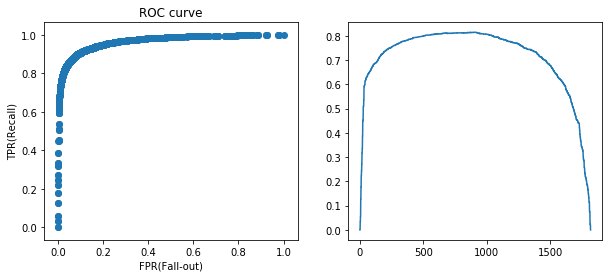

In [ ]:
# roc_curve(타겟값, prob of 1)
y_pred_proba = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
# print(roc)

# roc 시각화
plt.rcParams["figure.figsize"] = (10,4)
plt.subplot(121)
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

# 최적의 threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('idx:', optimal_idx, ', threshold:', optimal_threshold)

# auc 시각화
plt.subplot(122)
plt.plot(tpr-fpr);

# threshold 설정 및 레포트
y_pred_optimal = y_pred_proba >= optimal_threshold
print('Report \n',classification_report(y_val, y_pred_optimal))

# auc 점수
auc_score = roc_auc_score(y_val, y_pred_optimal)
print('최종 검증 정확도: ', accuracy_score(y_val, y_pred_optimal))
print('최종 f1 스코어',f1_score(y_val, y_pred_optimal))
print('최종 auc점수 : ', auc_score)

In [ ]:
params ={
    'n_estimators': [100, 200, 300],
    'max_depth':[9, 10, 11],
    'learning_rate':[0.1, 0.2, 0.3]
}

cb = CatBoostClassifier(task_type="GPU")
grid_cv = GridSearchCV(cb, param_grid=params, n_jobs=-1, )
grid_cv.fit(X_train, y_train)
print('best parameters : \n', grid_cv.best_params_)

# 최종 모델링

In [ ]:
# 캣부스트 사용
model = CatBoostClassifier(learning_rate = 0.1, max_depth = 10, n_estimators = 200, task_type="GPU")

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print('훈련 정확도', model.score(X_train, y_train))
print('검증 정확도', model.score(X_val, y_val))
print('Report \n',classification_report(y_val, y_pred))
print('f1 스코어',f1_score(y_val, y_pred))
print('auc점수 : ', roc_auc_score(y_val, y_pred))

0:	learn: 0.5731315	total: 35.2ms	remaining: 7.01s
1:	learn: 0.4876900	total: 68.2ms	remaining: 6.75s
2:	learn: 0.4245104	total: 101ms	remaining: 6.63s
3:	learn: 0.3767580	total: 133ms	remaining: 6.54s
4:	learn: 0.3396585	total: 166ms	remaining: 6.46s
5:	learn: 0.3153236	total: 199ms	remaining: 6.43s
6:	learn: 0.2945814	total: 232ms	remaining: 6.38s
7:	learn: 0.2778553	total: 273ms	remaining: 6.54s
8:	learn: 0.2673198	total: 303ms	remaining: 6.43s
9:	learn: 0.2574669	total: 339ms	remaining: 6.44s
10:	learn: 0.2498325	total: 376ms	remaining: 6.47s
11:	learn: 0.2443846	total: 434ms	remaining: 6.8s
12:	learn: 0.2401830	total: 503ms	remaining: 7.23s
13:	learn: 0.2360728	total: 539ms	remaining: 7.16s
14:	learn: 0.2322120	total: 590ms	remaining: 7.28s
15:	learn: 0.2296731	total: 628ms	remaining: 7.22s
16:	learn: 0.2271751	total: 666ms	remaining: 7.17s
17:	learn: 0.2250389	total: 697ms	remaining: 7.05s
18:	learn: 0.2230873	total: 744ms	remaining: 7.08s
19:	learn: 0.2213512	total: 779ms	remain

idx: 830 , threshold: 0.3365471301818729
Report 
               precision    recall  f1-score   support

           0       0.94      0.93      0.94     10244
           1       0.87      0.88      0.88      5377

    accuracy                           0.92     15621
   macro avg       0.91      0.91      0.91     15621
weighted avg       0.92      0.92      0.92     15621

최종 검증 정확도:  0.9156264003584917
최종 f1 스코어 0.8782785371259697
최종 auc점수 :  0.9081899513140302


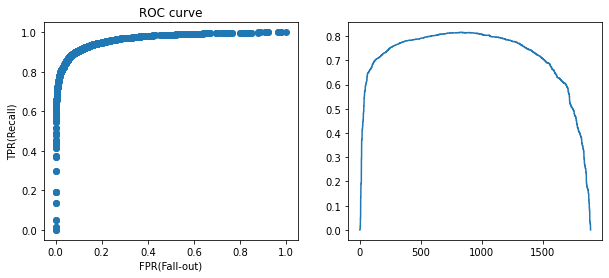

In [ ]:
# roc_curve(타겟값, prob of 1)
y_pred_proba = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
# print(roc)

# roc 시각화
plt.rcParams["figure.figsize"] = (10,4)
plt.subplot(121)
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

# 최적의 threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('idx:', optimal_idx, ', threshold:', optimal_threshold)

# auc 시각화
plt.subplot(122)
plt.plot(tpr-fpr);

# threshold 설정 및 레포트
y_pred_optimal = y_pred_proba >= optimal_threshold
print('Report \n',classification_report(y_val, y_pred_optimal))

# auc 점수
auc_score = roc_auc_score(y_val, y_pred_optimal)
print('최종 검증 정확도: ', accuracy_score(y_val, y_pred_optimal))
print('최종 f1 스코어',f1_score(y_val, y_pred_optimal))
print('최종 auc점수 : ', auc_score)

idx: 1072 , threshold: 0.46905030139281495
Report 
               precision    recall  f1-score   support

           0       0.94      0.93      0.93     12804
           1       0.87      0.89      0.88      6722

    accuracy                           0.91     19526
   macro avg       0.90      0.91      0.91     19526
weighted avg       0.92      0.91      0.91     19526

테스트 정확도 0.9150363617740449
f1 스코어 0.8772961058045555
auc점수 :  0.9082160941412145


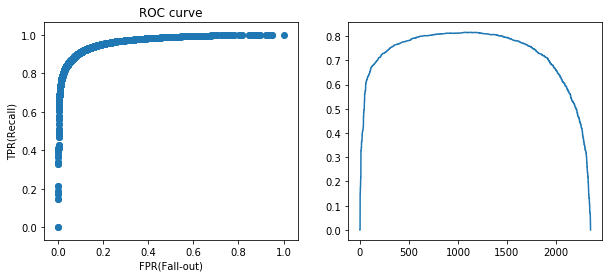

In [ ]:
# 테스트 데이터 성능확인
y_pred = model.predict(X_test)

# roc_curve(타겟값, prob of 1)
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

# roc 시각화
plt.rcParams["figure.figsize"] = (10,4)
plt.subplot(121)
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

# 최적의 threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('idx:', optimal_idx, ', threshold:', optimal_threshold)

# auc 시각화
plt.subplot(122)
plt.plot(tpr-fpr);

# threshold 설정 및 레포트
y_pred_optimal = y_pred_proba >= optimal_threshold
print('Report \n',classification_report(y_test, y_pred_optimal))

# auc 점수
auc_score = roc_auc_score(y_test, y_pred_optimal)
print('테스트 정확도', model.score(X_test, y_test))
print('f1 스코어',f1_score(y_test, y_pred_optimal))
print('auc점수 : ', auc_score)

- Test Set에서의 결과도 만족할 만큼 나왔다.
- Train Set에 과적합되지 않고 일반화가 잘 됐다고 볼 수 있다.
- 최종적으로 91.5%의 정확도로 착륙 지연을 예측하는 머신러닝 모델을 만들었다.

# 해석
## Feature Importance

In [ ]:
ntrain = train[features]

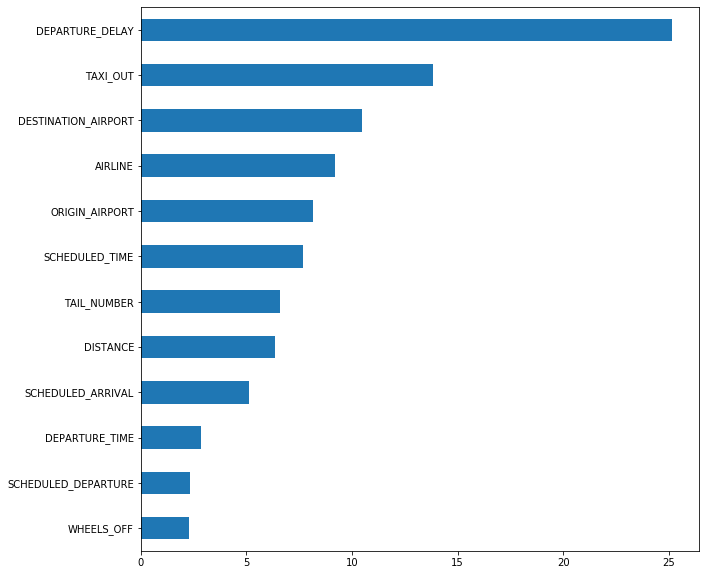

In [ ]:
# 특성중요도 확인
importances = pd.Series(model.feature_importances_, ntrain.columns)
plt.figure(figsize=(10,10))
importances.sort_values().plot.barh();

## Permutation Importance

In [ ]:
# Permutation Importance 확인
# permuter 정의
permuter = PermutationImportance(
    model, # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# 실제로 fit 의미보다 스코어 다시 계산하는 작업
permuter.fit(X_val, y_val);

feature_names = ntrain.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

SCHEDULED_ARRIVAL     -0.000371
WHEELS_OFF            -0.000346
TAIL_NUMBER            0.000090
SCHEDULED_DEPARTURE    0.000128
DEPARTURE_TIME         0.000755
ORIGIN_AIRPORT         0.003252
DESTINATION_AIRPORT    0.006120
AIRLINE                0.007016
DISTANCE               0.014506
SCHEDULED_TIME         0.026208
TAXI_OUT               0.064196
DEPARTURE_DELAY        0.317637
dtype: float64

In [ ]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.3176 ± 0.0057,DEPARTURE_DELAY
0.0642 ± 0.0024,TAXI_OUT
0.0262 ± 0.0019,SCHEDULED_TIME
0.0145 ± 0.0013,DISTANCE
0.0070 ± 0.0009,AIRLINE
0.0061 ± 0.0011,DESTINATION_AIRPORT
0.0033 ± 0.0026,ORIGIN_AIRPORT
0.0008 ± 0.0015,DEPARTURE_TIME
0.0001 ± 0.0007,SCHEDULED_DEPARTURE
0.0001 ± 0.0012,TAIL_NUMBER


### 가설1 : 출발 예정시간보다 출발에 지연된 시간이 클 수록 착륙 지연 확률은 늘어날 것이다.
- 총 출발 지연 시간이 가장 Model에 큰 영향을 끼친 걸 볼 수 있다.
- 다음으로 게이트에서 항공기가 이륙할 때까지 경과 시간도 도착 지연에 큰 영향을 미쳤다.
- 계획되어있는 비행시간과 거리도 무시 못할만큼의 영향을 미쳤다.

## PDP
- Permutation Importance에서 영향을 많이 끼친 4가지 Feature에 대해 PDPlot 확인

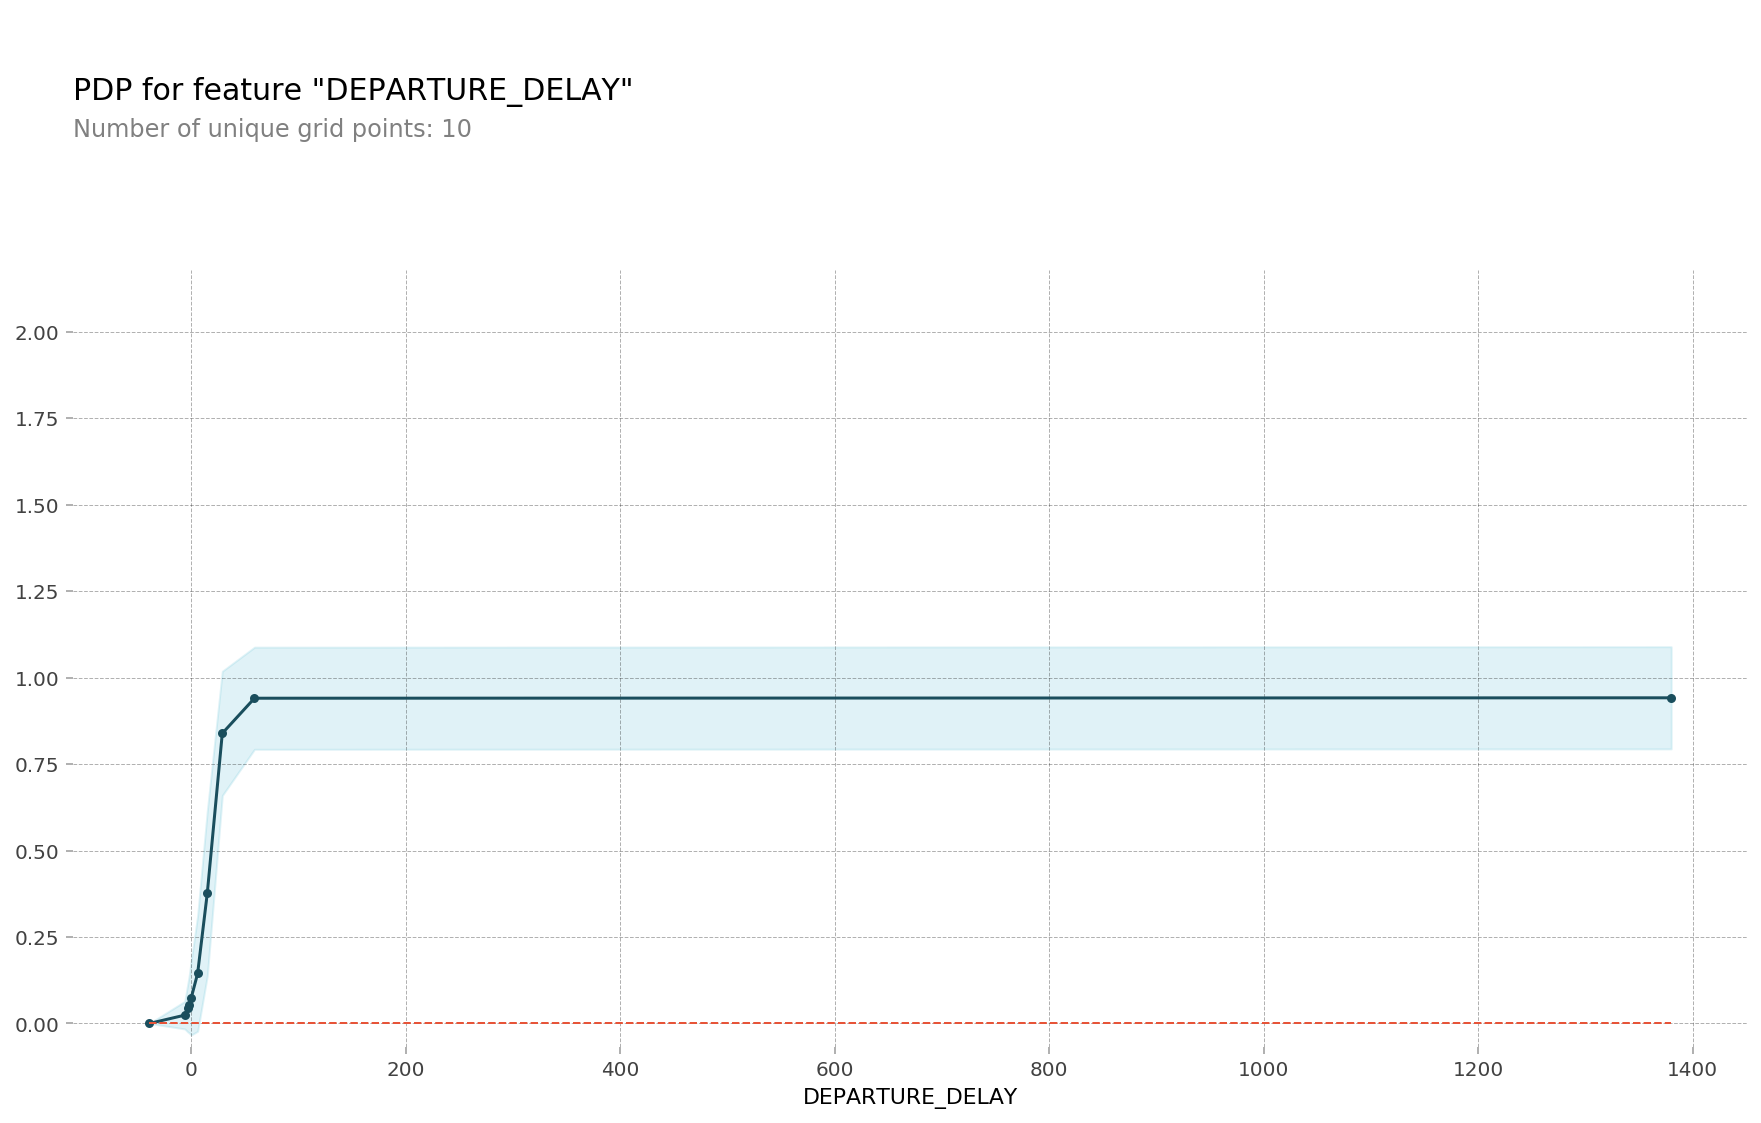

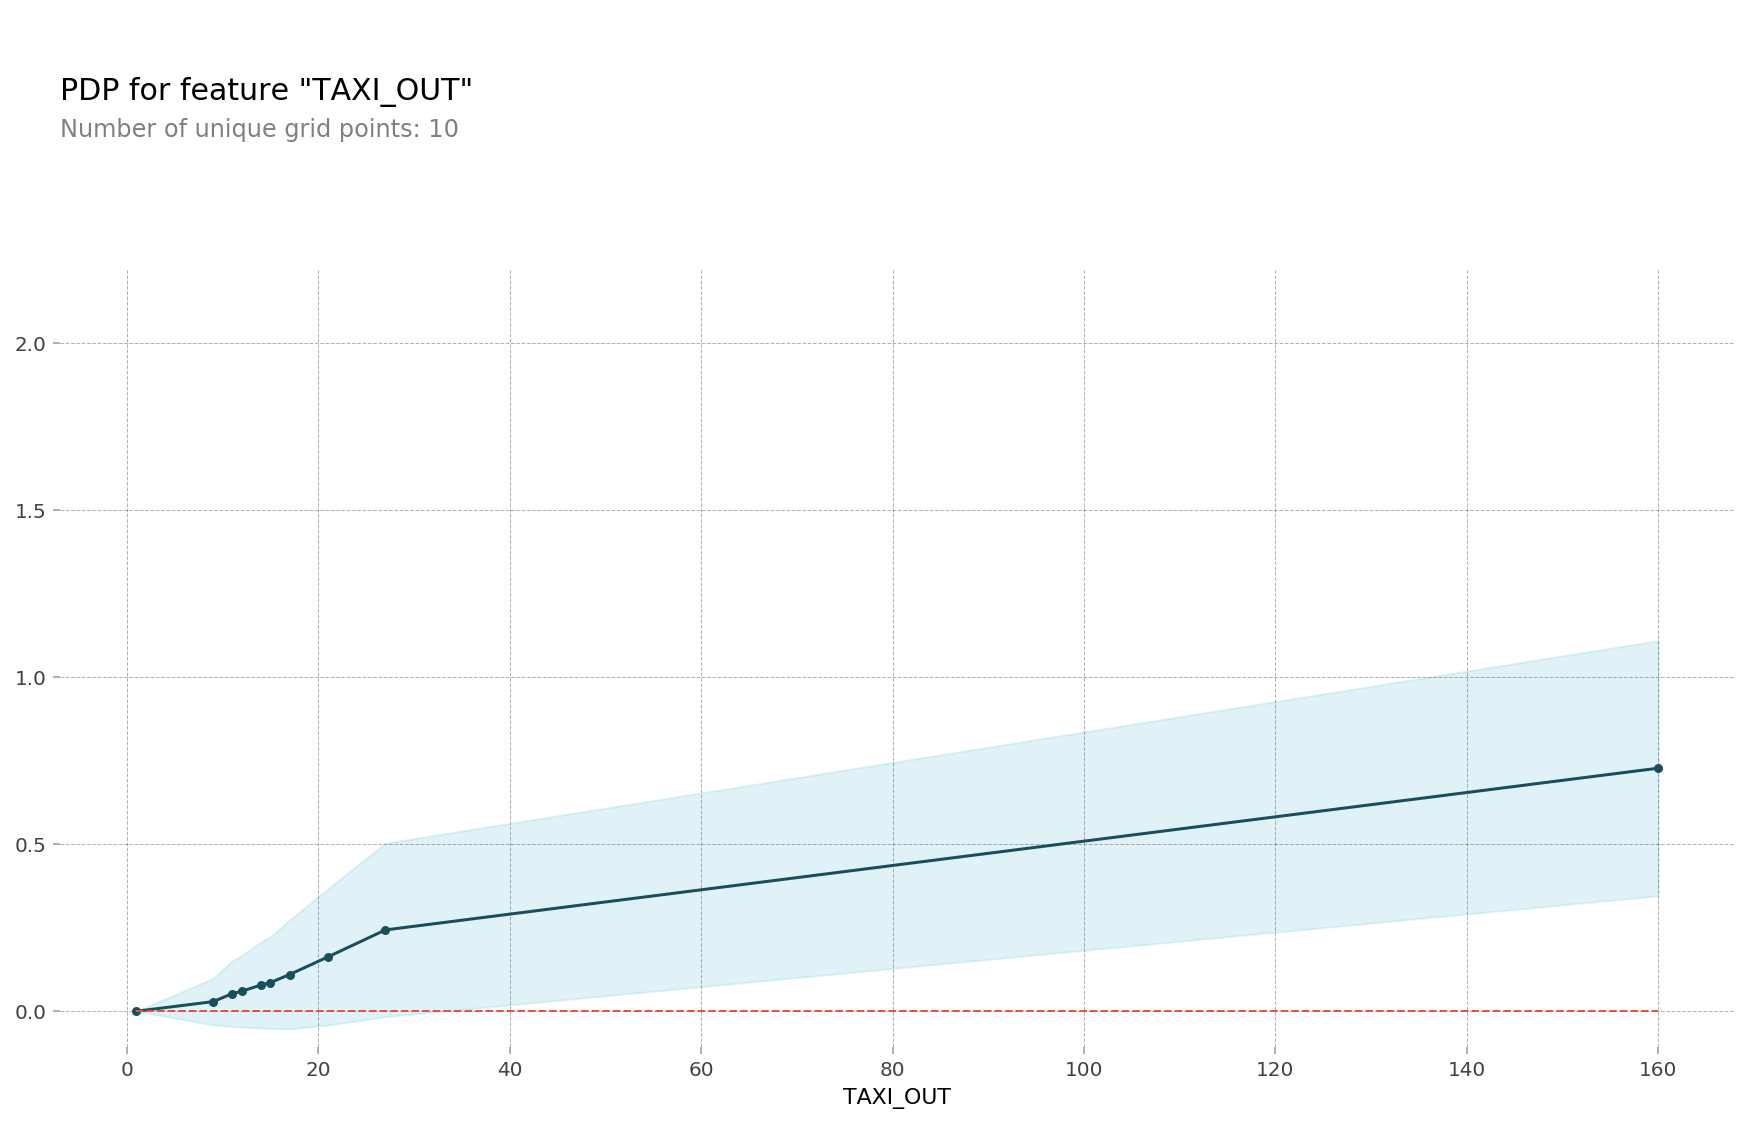

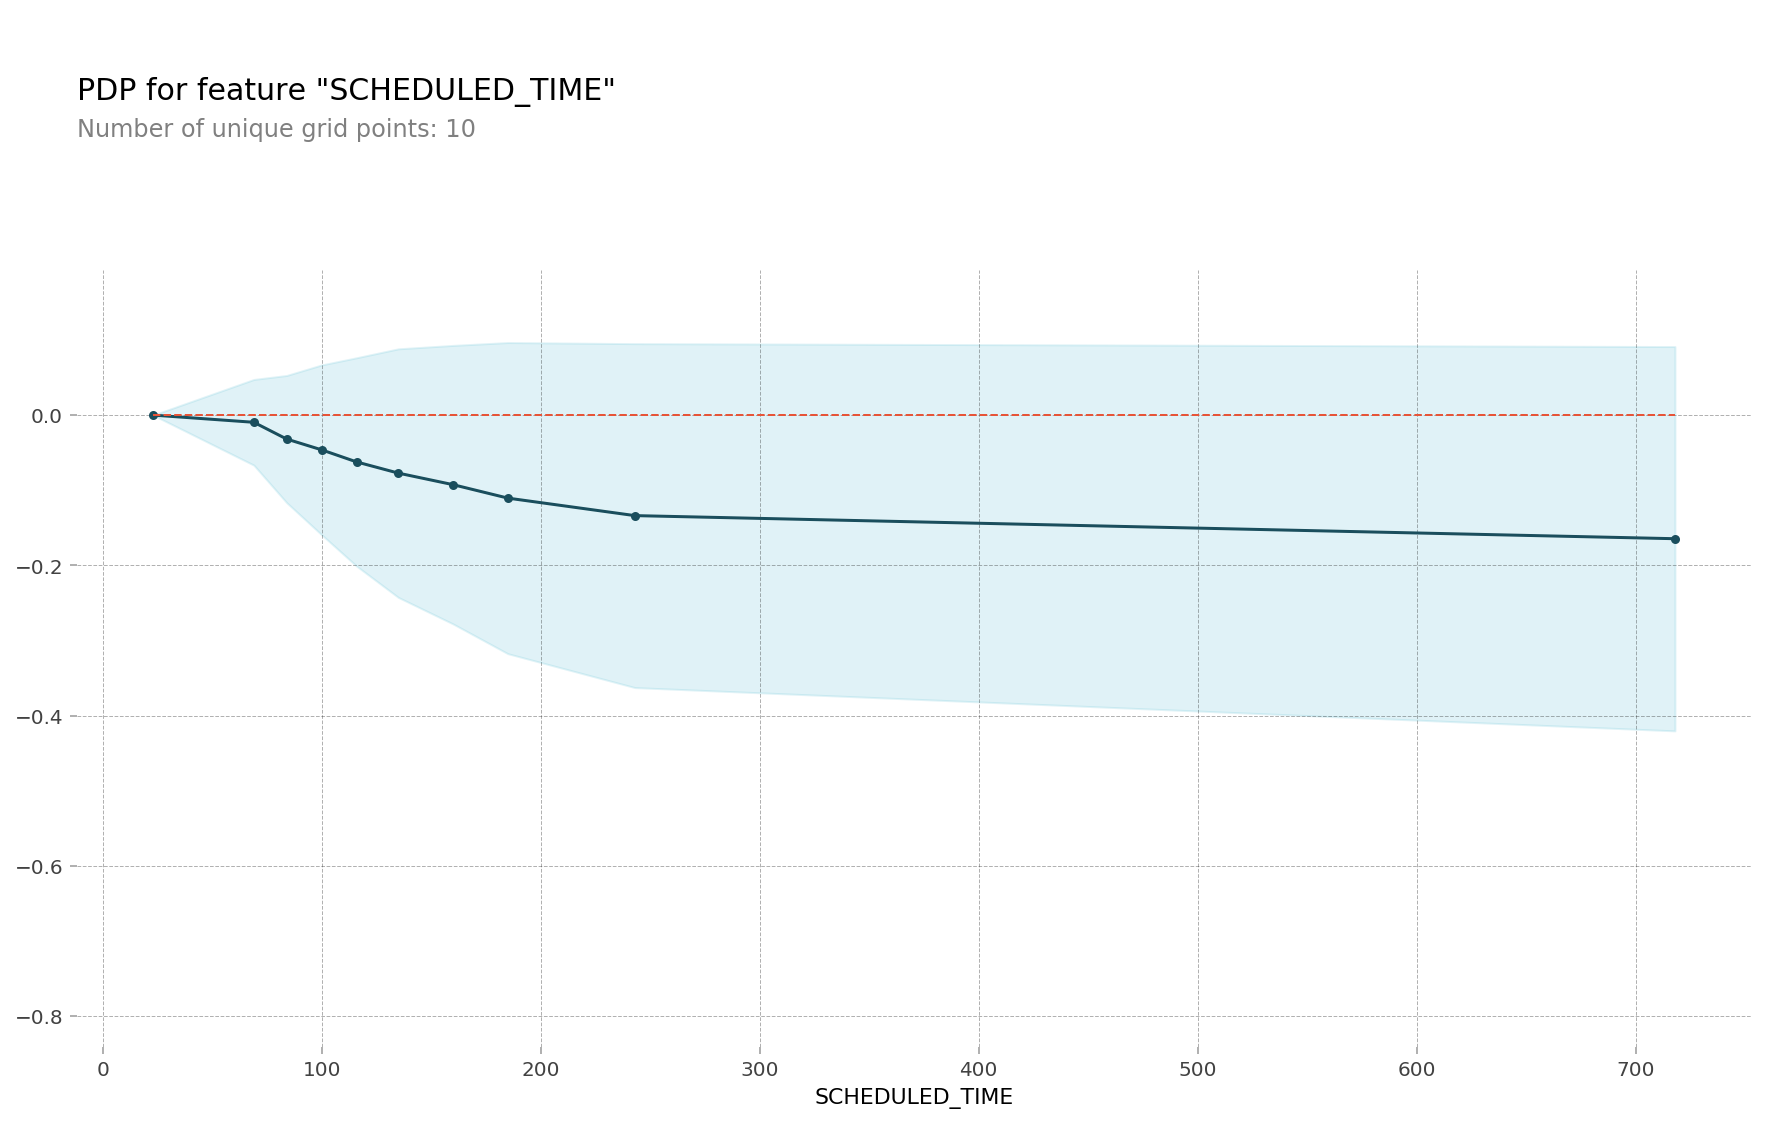

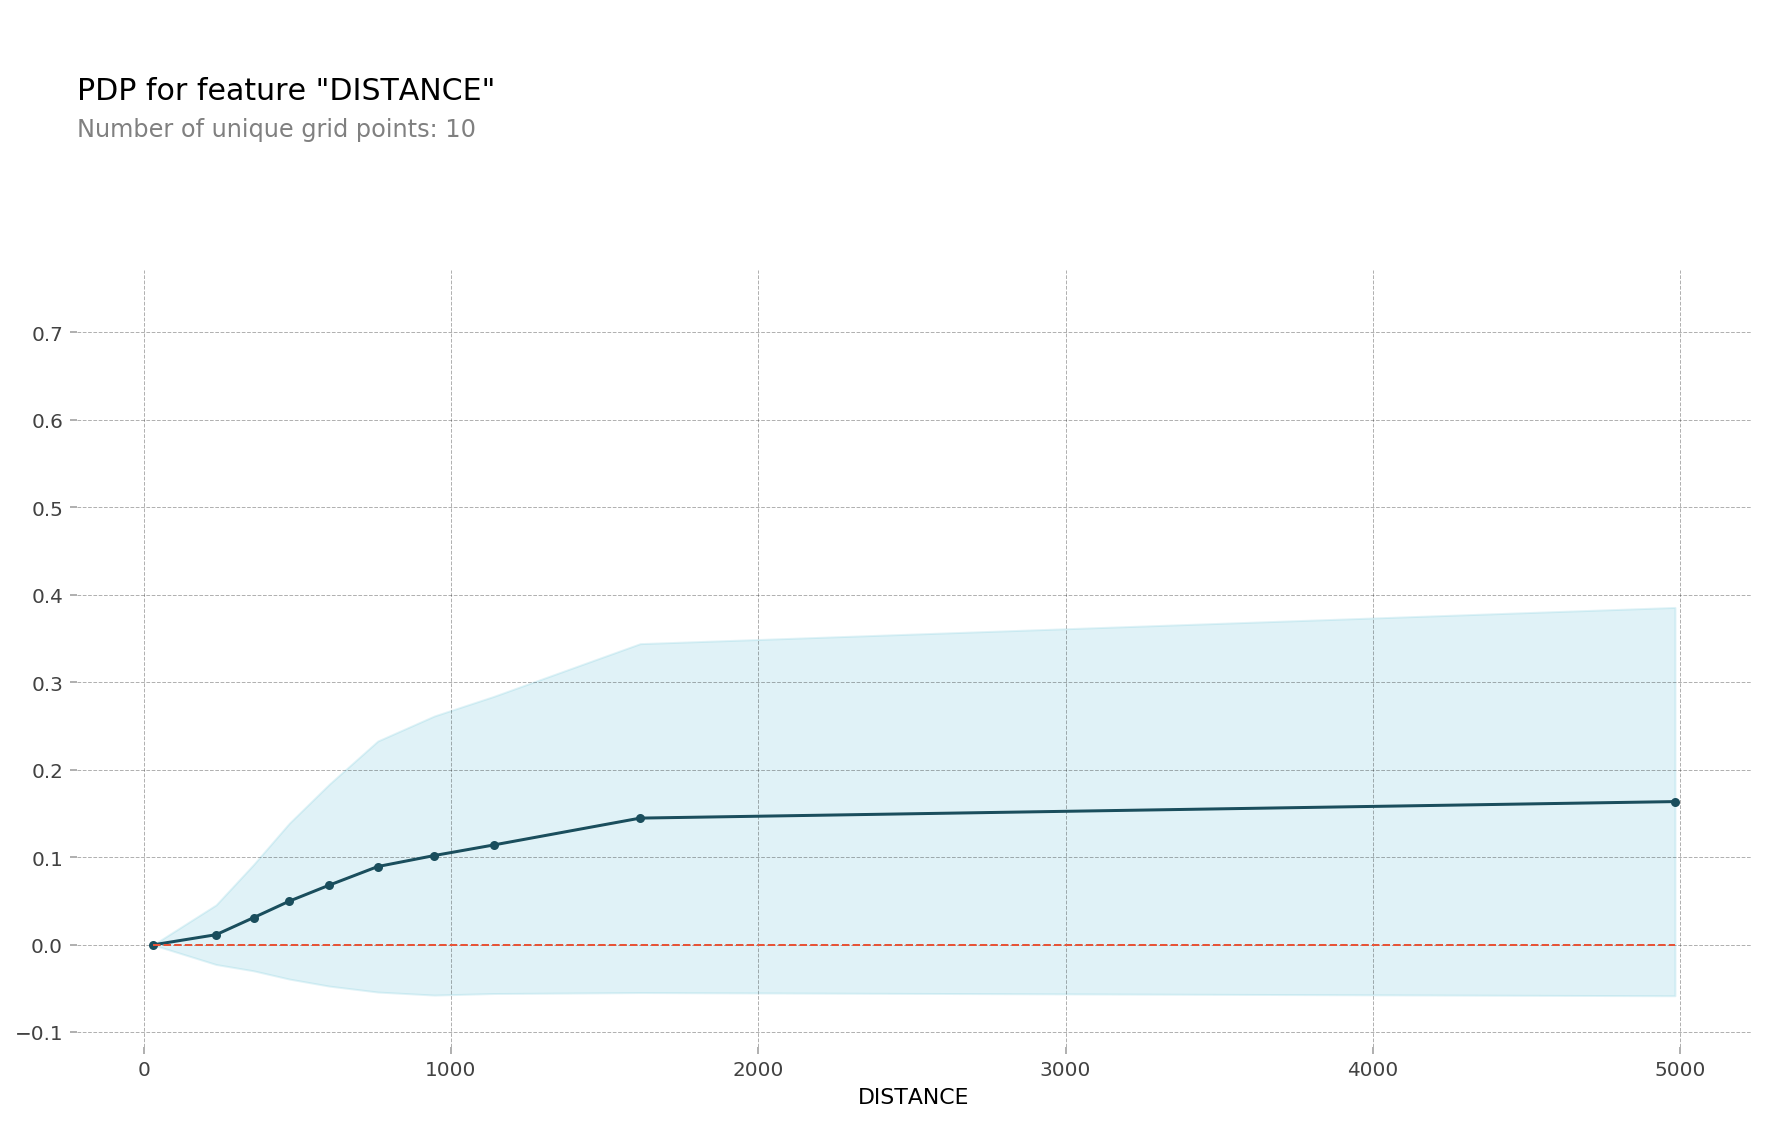

In [ ]:
# 화질
plt.rcParams['figure.dpi'] = 144

for i in ['DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME', 'DISTANCE']:
    feature = i
    isolated = pdp_isolate(
        model=model, 
        dataset=ntrain, 
        model_features=ntrain.columns, 
        feature=feature,
        grid_type='percentile', # default='percentile', or 'equal'
        num_grid_points=10 # default=10
    )
    pdp_plot(isolated, feature_name=feature);

- `SCHEDULED_TIME`가 음의 상관계수인 것을 제외하면 나머지는 모두 양의 상관계수를 보인다.

In [ ]:
row = ntrain.iloc[[1]]  # 중첩 brackets을 사용하면 결과물이 DataFrame
row

,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL
4828,9,515,108,15,1135,1122.0,-13.0,11.0,1133.0,50.0,110,1225


## SHAP
- SHAP을 통해 각 Feature의 영향력 확인


In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(ntrain.iloc[:100])
shap.force_plot(explainer.expected_value, shap_values, ntrain.iloc[:100])

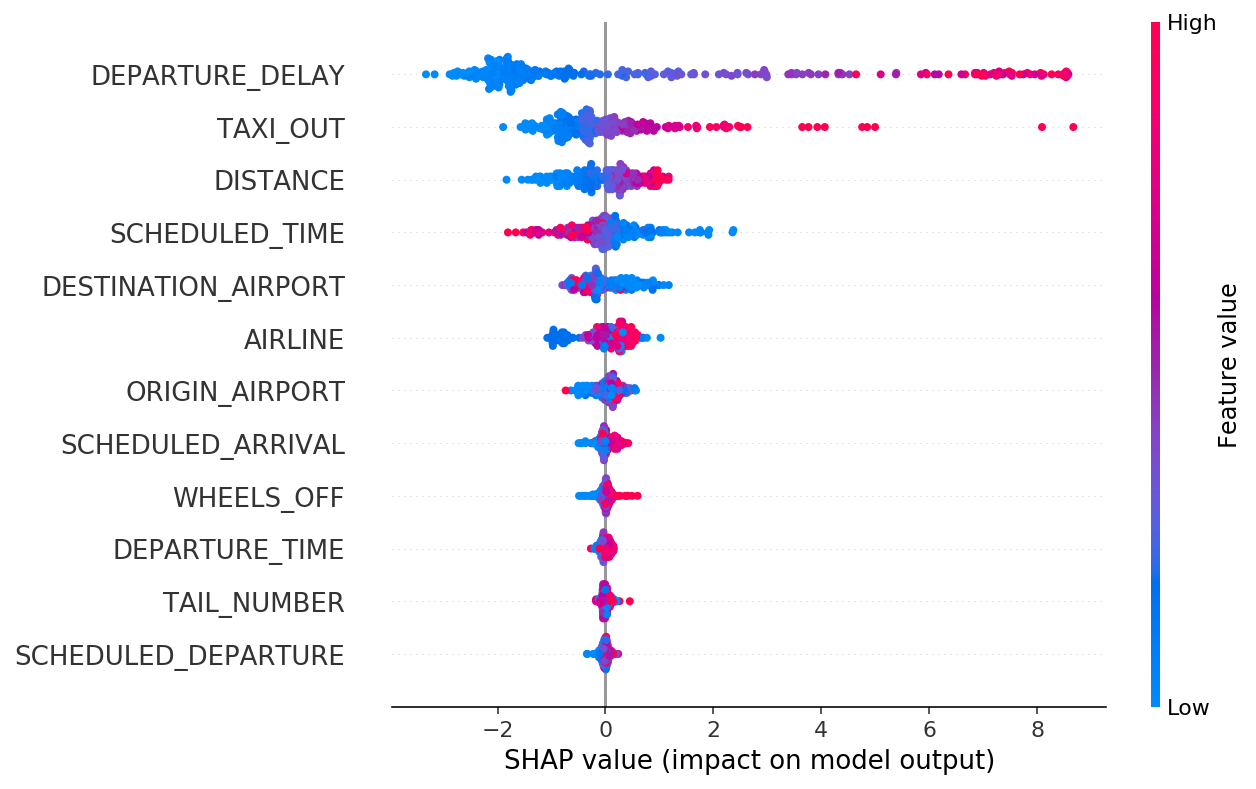

In [ ]:
shap_values = explainer.shap_values(ntrain.iloc[:300])
shap.summary_plot(shap_values, ntrain.iloc[:300])

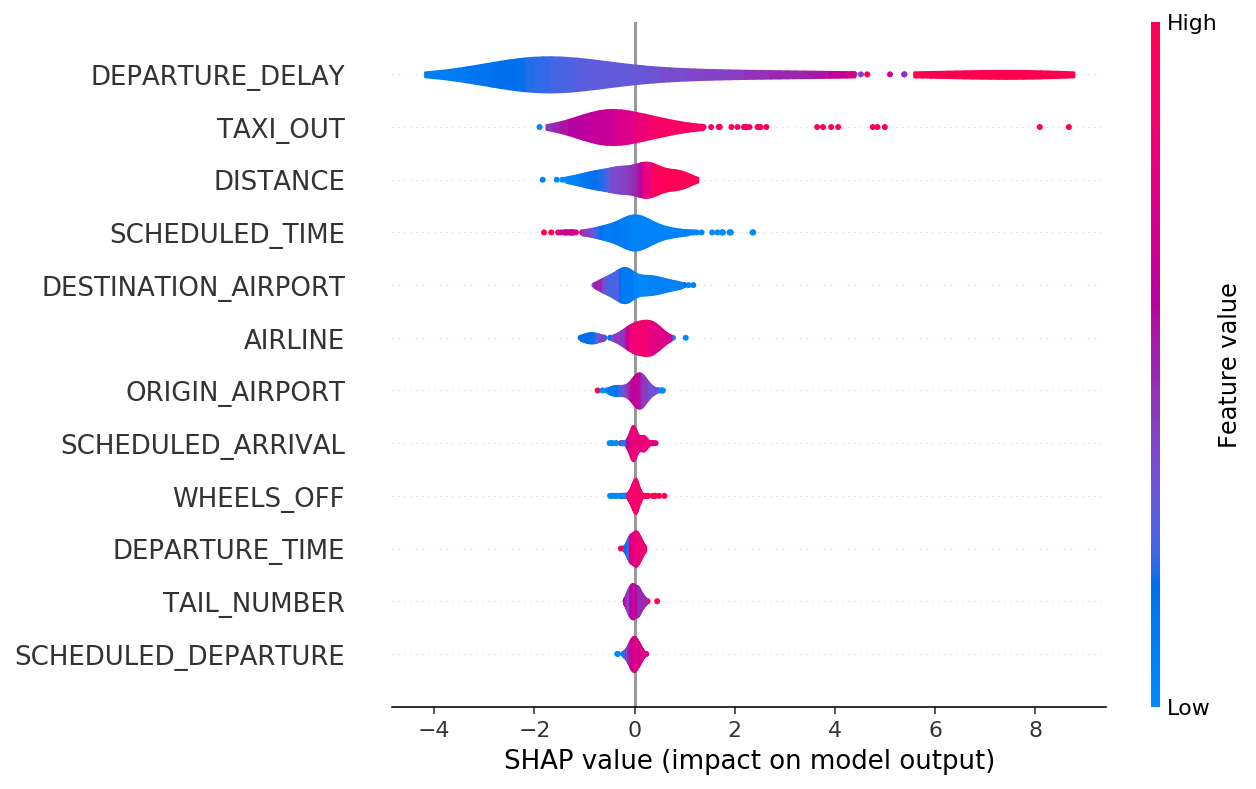

In [ ]:
shap.summary_plot(shap_values, ntrain.iloc[:300], plot_type="violin")

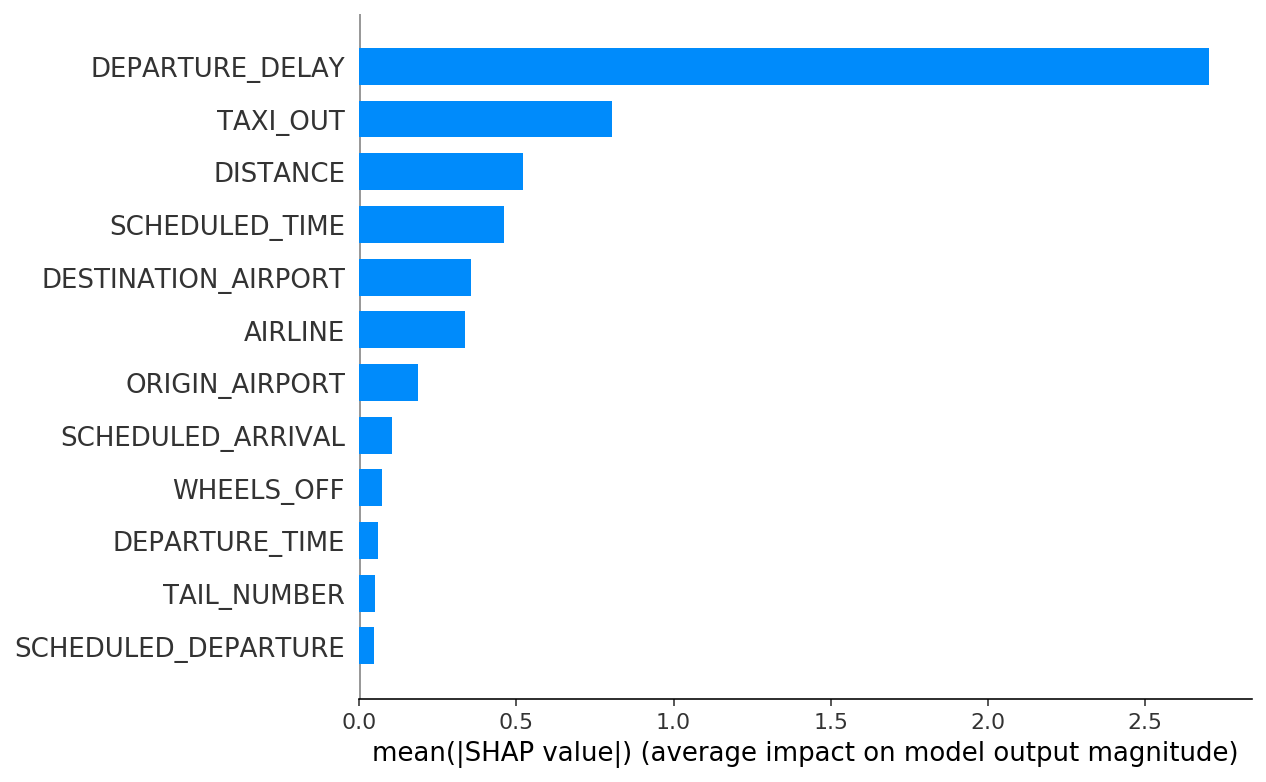

In [ ]:
# type ber
shap.summary_plot(shap_values, ntrain.iloc[:300], plot_type="bar")

In [ ]:
- Airline 특성이 착륙 지연 예측에 영향을 주므로 가설 ‘지연이 잦은 항공사가 있으므로 지연 확률을 줄이기 위한 고려사항이 된다.’라는 내용도 어느정도 검증이 된다.

- 각 그래프 확인 결과 Permutation importance와 마찬가지로 Departure delay의 영향력이 가장 크고 다음으로 taxi out, distance인 것을 확인할 수 있다.
## Insight
- 현재 Cost의 한계 때문에 10만개의 Data만 사용했음에도 착륙 지연에 관한 좋은 성능의 Modeling을 했다.
- 모든 Data를 활용한다면 더 좋은 성능을 이끌어 낼 수 있을 거라 생각하고, 그렇게 된다면 Date 정보도 예측에 활용 될 수 있다.
- 또한 현재 착륙 지연에 대한 예측을 할 수 밖에 없는 특성들이었는데, 기상 데이터와 항공 정비 이력에 관한 특성이 주어진다면 이륙 지연에 대한 예측이 가능해져 소비자 혹은 공항이나 항공사의 효율성과 비용절감에 더욱 크게 기여할 수 있을 거라고 생각한다.